In [1]:
import pandas as pd
from sqlalchemy import create_engine
from datetime import datetime, timedelta

# 設置MySQL資料庫連接
db_user = 'root'
db_password = '19970730'
db_host = '127.0.0.1'
db_name = 'sql_stock'

# 創建資料庫連接引擎
engine = create_engine(f'mysql+mysqlconnector://{db_user}:{db_password}@{db_host}/{db_name}')

# 設置日期範圍
#today = datetime(2024, 5, 25)
today = datetime.now().date()
one_year_ago = today - timedelta(days=1000)

# 格式化日期
today_str = today.strftime('%Y%m%d')
one_year_ago_str = one_year_ago.strftime('%Y%m%d')

# 可自由調整select的區間
# today_str = '20240813'
today_str = '20241231'
one_year_ago_str = '20210101'

# SQL 查詢 加權指數
query_daily_tx = f"""
SELECT *
FROM daily_tx
WHERE date >= '{one_year_ago_str}' AND date <= '{today_str}'
"""

# SQL 查詢 加權指數
query_daily_updown = f"""
SELECT *
FROM daily_updown
WHERE date >= '{one_year_ago_str}' AND date <= '{today_str}'
"""

# SQL 查詢 加權指數
query_tif_investors = f"""
SELECT *
FROM daily_tif_investors
WHERE date >= '{one_year_ago_str}' AND date <= '{today_str}'
"""

# SQL 查詢 加權指數
query_pc_ratio = f"""
SELECT *
FROM daily_pc_ratio
WHERE date >= '{one_year_ago_str}' AND date <= '{today_str}'
"""

# SQL 查詢 個股
query_stock = f"""
SELECT *
FROM daily_price
WHERE date >= '{one_year_ago_str}' AND date <= '{today_str}'
"""

# 使用 pd.read_sql 來執行查詢並讀取數據到 DataFrame
tif_investors_df_raw = pd.read_sql(query_tif_investors, engine)
# 使用 pd.read_sql 來執行查詢並讀取數據到 DataFrame
updown_df_raw = pd.read_sql(query_daily_updown, engine)
# 使用 pd.read_sql 來執行查詢並讀取數據到 DataFrame
tx_df_raw = pd.read_sql(query_daily_tx, engine)

pc_ratio_raw = pd.read_sql(query_pc_ratio, engine)

stock_df_raw = pd.read_sql(query_stock, engine)
stock_df_raw['Date'] = pd.to_datetime(stock_df_raw['Date'])

In [24]:
date_list = stock_df_raw['Date'].unique().tolist()

arms_index_list = pd.DataFrame(columns=['Date','TRIN'])

for day in date_list:

    tt = stock_df_raw[stock_df_raw['Date'] == day.strftime('%Y-%m-%d')]

    a = len(tt[tt['漲跌(+/-)'] == '+']) / len(tt[tt['漲跌(+/-)'] == '-']) 
    b = tt[tt['漲跌(+/-)'] == '+']['成交金額'].sum() / tt[tt['漲跌(+/-)'] == '-']['成交金額'].sum()
    TRIN = round(a/b , 3)
    temp = pd.DataFrame({
    'Date':[day],
    'TRIN':[TRIN]
    })

    # 删除全为NA的列，避免可能出现的警告
    temp.dropna(axis=1, how='all', inplace=True)

    if not temp.empty:
            arms_index_list = pd.concat([arms_index_list, temp], ignore_index=True)


C:\Users\USER\AppData\Local\Temp\ipykernel_8876\2356106293.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  arms_index_list = pd.concat([arms_index_list, temp], ignore_index=True)


In [2]:
plot_size = len(tif_investors_df_raw)
plot_size = 300
x_lab = 20

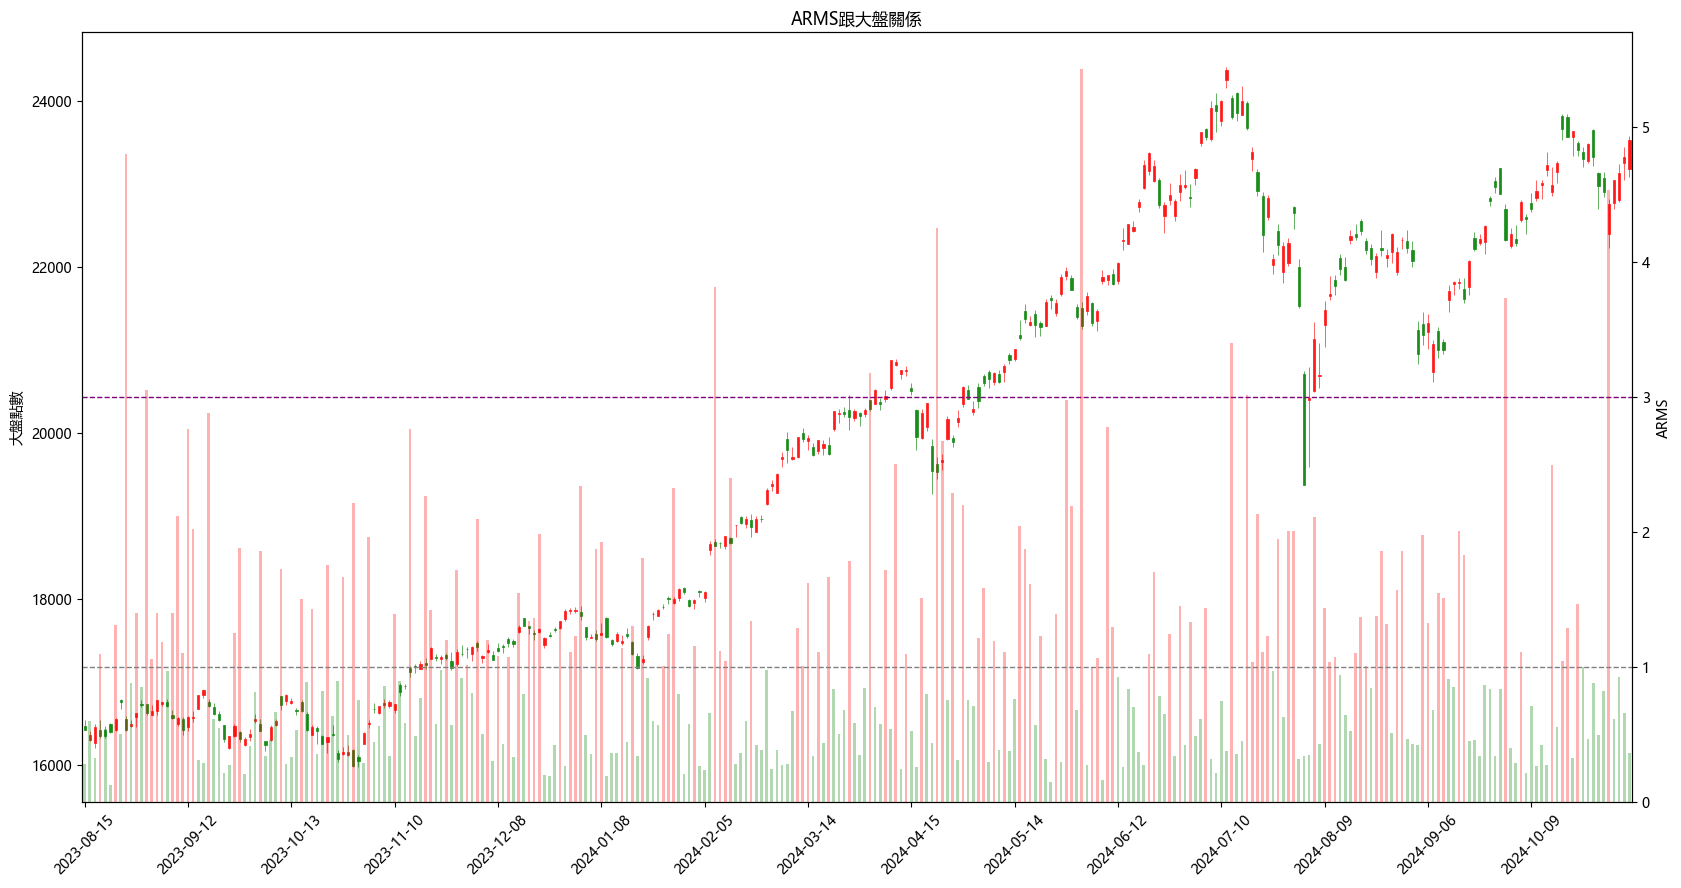

In [25]:
import mplfinance as mpf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


tx_df_raw['Date'] = pd.to_datetime(tx_df_raw['Date'])
updown_df_raw['Date'] = pd.to_datetime(updown_df_raw['Date'])


# 準備 每日漲跌個數
# updown_df_raw['差距'] = 100 * (updown_df_raw['總上漲家數'] - updown_df_raw['總下跌家數']) / (updown_df_raw['總上漲家數'] + updown_df_raw['總下跌家數'])
arms_index_list_forplot = arms_index_list.copy()
arms_index_list_forplot.set_index('Date', inplace=True)
arms_index_list_forplot.index = arms_index_list_forplot.index.strftime('%Y-%m-%d')

tx_df_forplot = tx_df_raw.copy()
tx_df_forplot.rename(columns={'開盤價': 'Open', '最高價': 'High', '最低價': 'Low', '最後成交價': 'Close'}, inplace=True)
tx_df_forplot.set_index('Date', inplace=True)


tx_df_raw_100 = tx_df_forplot.tail(plot_size)
arms_index_list_100 = arms_index_list_forplot.tail(plot_size)

# 設置中文字體
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 使用微軟正黑體 (可根據系統字體選擇)
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題


# 假設你的 dataframe 含有必要的 OHLC 數據 (Open, High, Low, Close)
ohlc_data = tx_df_raw_100[['Open', 'High', 'Low', 'Close']]

# 自定義顏色樣式，上漲為紅色，下跌為綠色
my_color = mpf.make_marketcolors(up='red', down='green', edge='inherit', wick='inherit', volume='inherit')

# 自定義樣式
my_style = mpf.make_mpf_style(marketcolors=my_color , facecolor='white')

# 設置主圖和次圖
fig, ax1 = plt.subplots(figsize=(20,10))
# 設定整體背景顏色

# 繪製蠟燭圖到 ax1，使用自定義的顏色樣式
mpf.plot(ohlc_data, type='candle', ax=ax1, volume=False, style=my_style , datetime_format='%Y-%m-%d')
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# 旋轉 x 軸標籤以便更清楚顯示
plt.xticks(rotation=45)

# 創建一個共享 X 軸但有不同 Y 軸的次圖 ax2
ax2 = ax1.twinx()

# 繪製小外資的正負長條圖到 ax2
arms_index_list_100['TRIN'].plot(kind='bar', color=['red' if v >= 1 else 'green' for v in arms_index_list_100['TRIN']], ax=ax2, alpha=0.3)  # 調整透明度以顯示蠟燭圖

ax2.axhline(y=3, color='purple', linestyle='--', linewidth=1)
ax2.axhline(y=1, color='gray', linestyle='--', linewidth=1)
# 設定 x 軸只顯示日期

ax1.set_xticks(ax1.get_xticks()[::x_lab])  # 每隔5个标签显示一个


# 繪製 10MA 移動平均線到 ax1
#ax1.plot(tx_df_raw['10MA'].index, tx_df_raw['10MA'], label='10MA', color='blue', linewidth=2)

# 設定標題和軸標籤
plt.title('ARMS跟大盤關係')
ax1.set_ylabel('大盤點數')
ax2.set_ylabel('ARMS')

# 顯示圖表
plt.show()


In [ ]:
import numpy as np
import warnings
# 計算訊號出來後隔天開盤直接買
# 出場訊號出來後 隔天開盤直接賣
# 忽略 FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

MA = '10MA'

tx_df_raw['hold'] = np.nan
condition_by = tx_df_raw['pc_ratio'] < -30
condition_sell = tx_df_raw['20MApc_ratio'] > 0

tx_df_raw.loc[condition_by, 'hold'] = 1
tx_df_raw.loc[condition_sell, 'hold'] = 0

tx_df_raw['hold'].ffill(inplace=True)
tx_df_raw['hold'] = tx_df_raw['hold'].fillna(0)

# 計算進出

day_list = tx_df_raw['Date'].unique().tolist()
earm_data1 = pd.DataFrame(columns=['buy_date','sell_date','buy_open','sell_open','earn'])

sell_date = pd.to_datetime("1911-01-01")  # Example Timestamp

for day in day_list:
        today_str = day.strftime('%Y-%m-%d')
        stock_df_today = tx_df_raw[tx_df_raw['Date'] == today_str].copy() 

        if((stock_df_today['hold'].iloc[0] == 1) & ( pd.to_datetime(today_str) > sell_date)): # 符合條件第一天

                buy_close = tx_df_raw[tx_df_raw['Date'] > today_str]['開盤價'].iloc[0] 
                buy_date = tx_df_raw[tx_df_raw['Date'] > today_str]['Date'].iloc[0] 

                
                sell_date = tx_df_raw[(tx_df_raw['hold'] == 0) & (tx_df_raw['Date'] > today_str)]['Date'].iloc[0] 
                sell_date = pd.to_datetime(sell_date)
                sell_open = tx_df_raw[(tx_df_raw['Date'] > sell_date)]['開盤價'].iloc[0] 
                
                earn = sell_open - buy_close

                result_df = pd.DataFrame({
                        'buy_date': [buy_date],
                        'sell_date': [sell_date],
                        'buy_open': [buy_close],
                        'sell_open': [sell_open],
                        'earn': [earn]
                        })

                # 删除全为NA的列，避免可能出现的警告
                result_df.dropna(axis=1, how='all', inplace=True)

                if not result_df.empty:
                        earm_data1 = pd.concat([earm_data1, result_df], ignore_index=True)


earm_data1

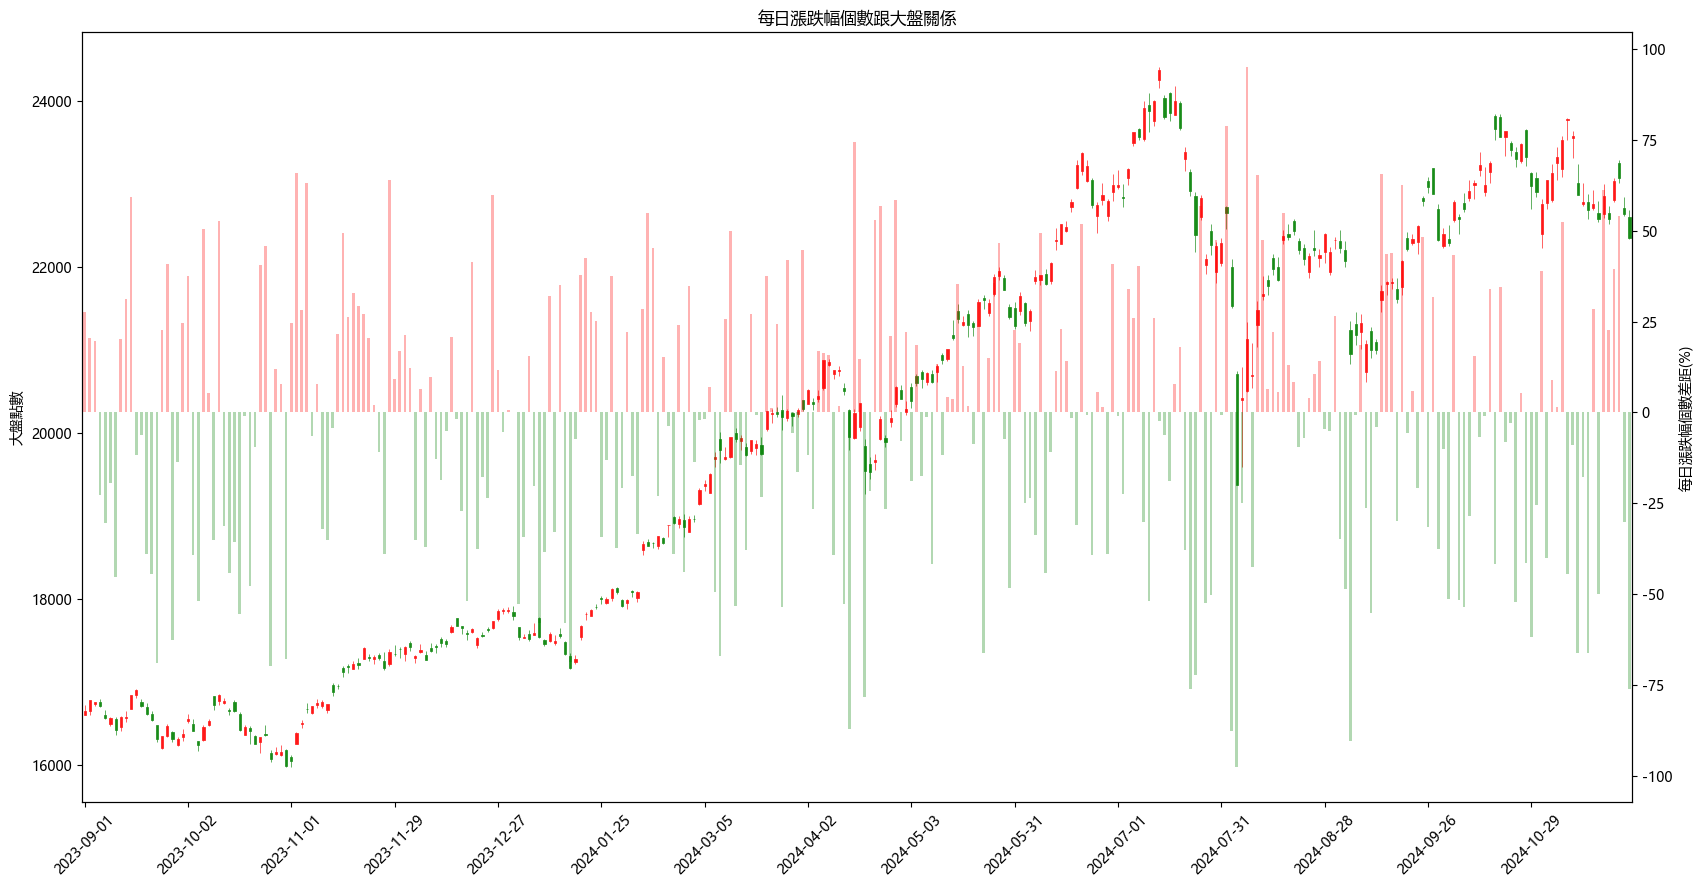

In [ ]:
import mplfinance as mpf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


tx_df_raw['Date'] = pd.to_datetime(tx_df_raw['Date'])
updown_df_raw['Date'] = pd.to_datetime(updown_df_raw['Date'])


# 準備 每日漲跌個數
updown_df_raw['差距'] = 100 * (updown_df_raw['總上漲家數'] - updown_df_raw['總下跌家數']) / (updown_df_raw['總上漲家數'] + updown_df_raw['總下跌家數'])
updown_df_forplot = updown_df_raw.copy()
updown_df_forplot.set_index('Date', inplace=True)
updown_df_forplot.index = updown_df_forplot.index.strftime('%Y-%m-%d')

tx_df_forplot = tx_df_raw.copy()
tx_df_forplot.rename(columns={'開盤價': 'Open', '最高價': 'High', '最低價': 'Low', '最後成交價': 'Close'}, inplace=True)
tx_df_forplot.set_index('Date', inplace=True)


tx_df_raw_100 = tx_df_forplot.tail(plot_size)
updown_df_raw_100 = updown_df_forplot.tail(plot_size)

# 設置中文字體
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 使用微軟正黑體 (可根據系統字體選擇)
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題


# 假設你的 dataframe 含有必要的 OHLC 數據 (Open, High, Low, Close)
ohlc_data = tx_df_raw_100[['Open', 'High', 'Low', 'Close']]

# 自定義顏色樣式，上漲為紅色，下跌為綠色
my_color = mpf.make_marketcolors(up='red', down='green', edge='inherit', wick='inherit', volume='inherit')

# 自定義樣式
my_style = mpf.make_mpf_style(marketcolors=my_color , facecolor='white')

# 設置主圖和次圖
fig, ax1 = plt.subplots(figsize=(20,10))

# 繪製蠟燭圖到 ax1，使用自定義的顏色樣式
mpf.plot(ohlc_data, type='candle', ax=ax1, volume=False, style=my_style , datetime_format='%Y-%m-%d')
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# 旋轉 x 軸標籤以便更清楚顯示
plt.xticks(rotation=45)

# 創建一個共享 X 軸但有不同 Y 軸的次圖 ax2
ax2 = ax1.twinx()

# 繪製小外資的正負長條圖到 ax2
updown_df_raw_100['差距'].plot(kind='bar', color=['red' if v >= 0 else 'green' for v in updown_df_raw_100['差距']], ax=ax2, alpha=0.3)  # 調整透明度以顯示蠟燭圖

# 設定 x 軸只顯示日期

ax1.set_xticks(ax1.get_xticks()[::x_lab])  # 每隔5个标签显示一个


# 繪製 10MA 移動平均線到 ax1
#ax1.plot(tx_df_raw['10MA'].index, tx_df_raw['10MA'], label='10MA', color='blue', linewidth=2)

# 設定標題和軸標籤
plt.title('每日漲跌幅個數跟大盤關係')
ax1.set_ylabel('大盤點數')
ax2.set_ylabel('每日漲跌幅個數差距(%)')

# 顯示圖表
plt.show()


C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


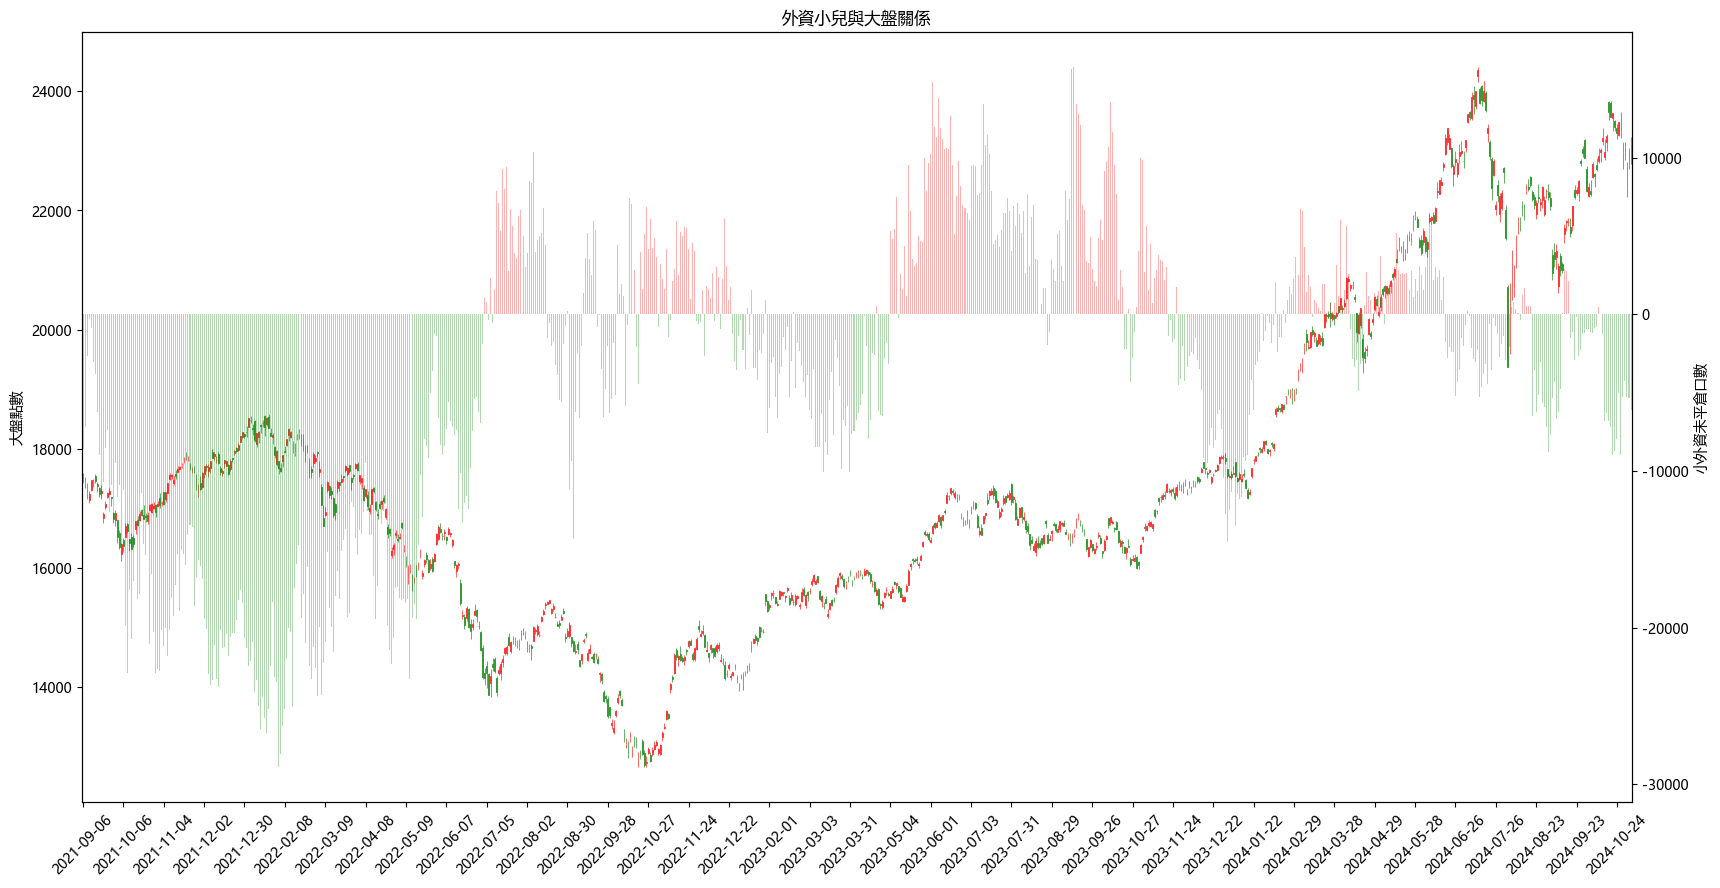

In [46]:
import mplfinance as mpf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 五大特定淨部位
top5_sp = tif_investors_df_raw['買方前五大交易人合計'] - tif_investors_df_raw['賣方前五大交易人合計']
# 大外資 = 五大減投信 (投信應該依定會進去前五大)
big_foreign = top5_sp - tif_investors_df_raw['投信未平倉餘額口數']
# 小外資
small_foreign = tif_investors_df_raw['外資未平倉餘額口數'] - big_foreign

tif_investors_df_raw['大外資']  = big_foreign
tif_investors_df_raw['小外資']  = small_foreign


# 将 'Date' 列转换为 datetime 类型
tif_investors_df_raw['Date'] = pd.to_datetime(tif_investors_df_raw['Date'])
tx_df_raw['Date'] = pd.to_datetime(tx_df_raw['Date'])  # 假设你有一个 Date 列


tx_df_raw.loc[:, '5MA'] = tx_df_raw['最後成交價'].rolling(5).mean()
tx_df_raw.loc[:, '8MA'] = tx_df_raw['最後成交價'].rolling(8).mean()
tx_df_raw.loc[:, '10MA'] = tx_df_raw['最後成交價'].rolling(10).mean()
tx_df_raw.loc[:, '20MA']= tx_df_raw['最後成交價'].rolling(20).mean()
tx_df_raw.loc[:, '60MA']= tx_df_raw['最後成交價'].rolling(60).mean()
tx_df_raw.loc[:, '240MA']= tx_df_raw['最後成交價'].rolling(240).mean()

tx_df_raw = tx_df_raw.fillna(0)

tif_investors_forplot = tif_investors_df_raw.copy()
tif_investors_forplot.set_index('Date', inplace=True)
tif_investors_forplot.index = tif_investors_forplot.index.strftime('%Y-%m-%d')

tx_df_raw_100 = tx_df_forplot.tail(plot_size)
tif_investors_df_raw_100 = tif_investors_forplot.tail(plot_size)


# 設置中文字體
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 使用微軟正黑體 (可根據系統字體選擇)
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題


# 假設你的 dataframe 含有必要的 OHLC 數據 (Open, High, Low, Close)
ohlc_data = tx_df_raw_100[['Open', 'High', 'Low', 'Close']]

# 自定義顏色樣式，上漲為紅色，下跌為綠色
my_color = mpf.make_marketcolors(up='red', down='green', edge='inherit', wick='inherit', volume='inherit')

# 自定義樣式
my_style = mpf.make_mpf_style(marketcolors=my_color)

# 設置主圖和次圖
fig, ax1 = plt.subplots(figsize=(20,10))

# 繪製蠟燭圖到 ax1，使用自定義的顏色樣式
mpf.plot(ohlc_data, type='candle', ax=ax1, volume=False, style=my_style)

# 設定 x 軸只顯示日期
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # 格式化日期顯示
ax1.xaxis.set_major_locator(mdates.AutoDateLocator())  # 自動設置日期間隔

# 旋轉 x 軸標籤以便更清楚顯示
plt.xticks(rotation=45)

# 創建一個共享 X 軸但有不同 Y 軸的次圖 ax2
ax2 = ax1.twinx()

# 繪製小外資的正負長條圖到 ax2
tif_investors_df_raw_100['小外資'].plot(kind='bar', 
                                       color=['red' if v >= 0 else 'green' for v in tif_investors_df_raw_100['小外資']],
                                       ax=ax2, alpha=0.3)  # 調整透明度以顯示蠟燭圖

ax1.set_xticks(ax1.get_xticks()[::x_lab])  # 每隔5个标签显示一个

# 繪製 10MA 移動平均線到 ax1
#ax1.plot(tx_df_raw['10MA'].index, tx_df_raw['10MA'], label='10MA', color='blue', linewidth=2)

# 設定標題和軸標籤
plt.title('外資小兒與大盤關係')
ax1.set_ylabel('大盤點數')
ax2.set_ylabel('小外資未平倉口數')

# 顯示圖表
plt.show()


In [10]:
plot_size = 100
x_lab = 2

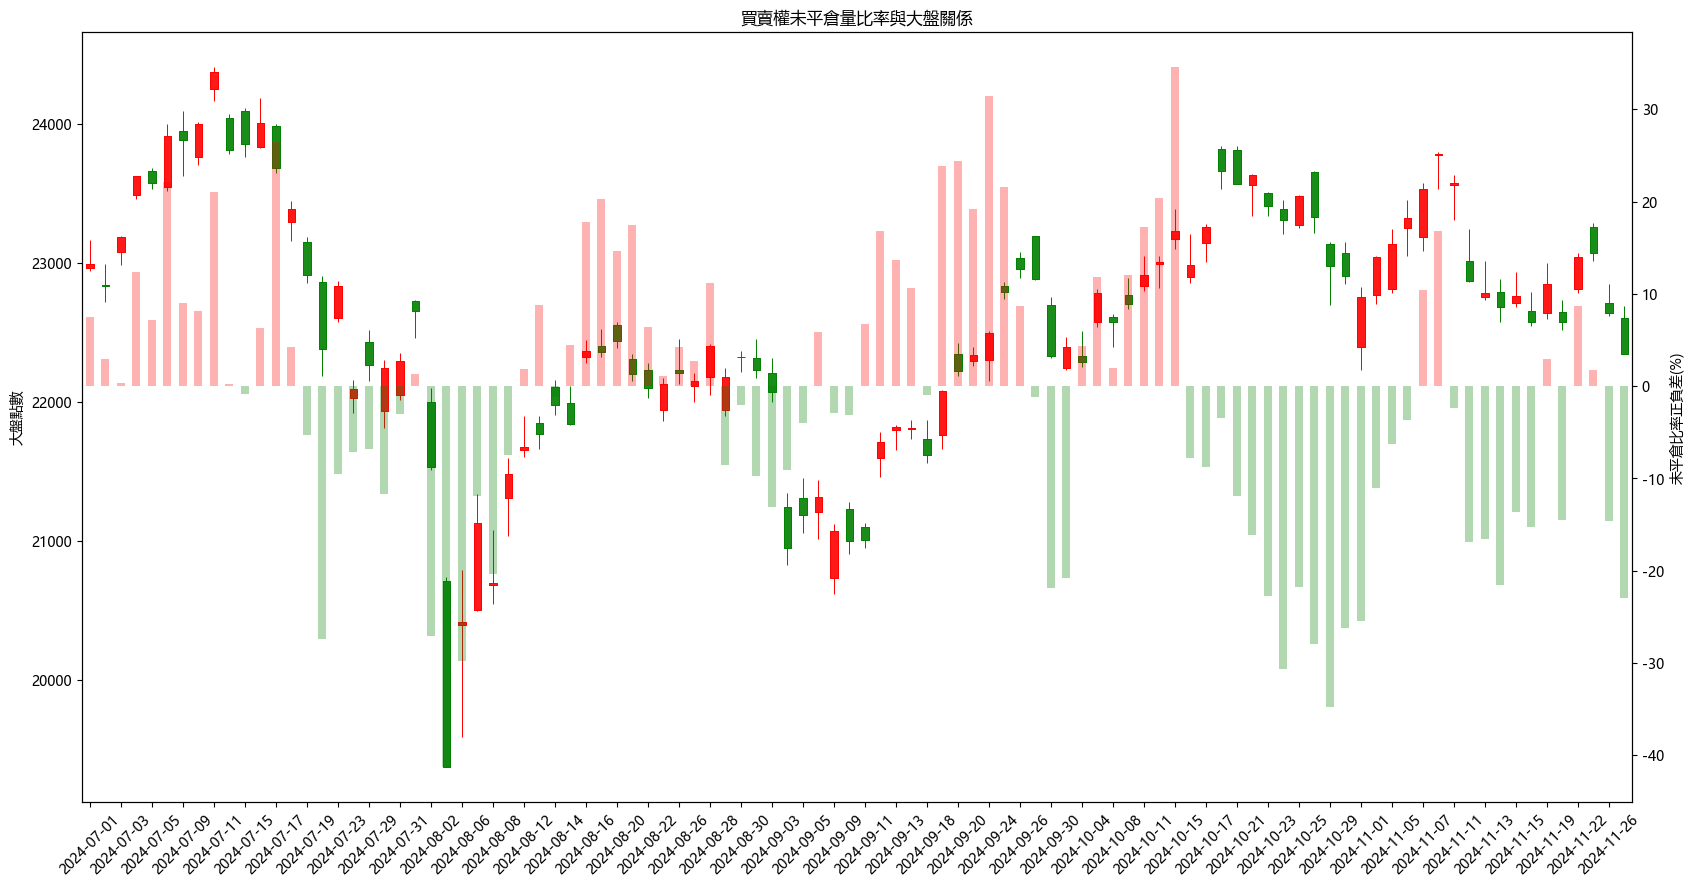

In [11]:
import mplfinance as mpf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

pc_ratio_forplot = pc_ratio_raw.copy()
pc_ratio_forplot['Date'] = pd.to_datetime(pc_ratio_forplot['Date'])

pc_ratio_forplot.set_index('Date', inplace=True)
pc_ratio_forplot.index = pc_ratio_forplot.index.strftime('%Y-%m-%d')
pc_ratio_forplot['買賣權未平倉量比率'] = pc_ratio_forplot['買賣權未平倉量比率'] - 100


tx_df_raw_100 = tx_df_forplot.tail(plot_size)
pc_ratio_forplot_100 = pc_ratio_forplot.tail(plot_size)


# 設置中文字體
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 使用微軟正黑體 (可根據系統字體選擇)
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題


# 假設你的 dataframe 含有必要的 OHLC 數據 (Open, High, Low, Close)
ohlc_data = tx_df_raw_100[['Open', 'High', 'Low', 'Close']]

# 自定義顏色樣式，上漲為紅色，下跌為綠色
my_color = mpf.make_marketcolors(up='red', down='green', edge='inherit', wick='inherit', volume='inherit')

# 自定義樣式
my_style = mpf.make_mpf_style(marketcolors=my_color)

# 設置主圖和次圖
fig, ax1 = plt.subplots(figsize=(20,10))

# 繪製蠟燭圖到 ax1，使用自定義的顏色樣式
mpf.plot(ohlc_data, type='candle', ax=ax1, volume=False, style=my_style)

# 設定 x 軸只顯示日期
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # 格式化日期顯示
ax1.xaxis.set_major_locator(mdates.AutoDateLocator())  # 自動設置日期間隔

# 旋轉 x 軸標籤以便更清楚顯示
plt.xticks(rotation=45)

# 創建一個共享 X 軸但有不同 Y 軸的次圖 ax2
ax2 = ax1.twinx()

# 繪製小外資的正負長條圖到 ax2
pc_ratio_forplot_100['買賣權未平倉量比率'].plot(kind='bar', 
                                       color=['red' if v >= 0 else 'green' for v in pc_ratio_forplot_100['買賣權未平倉量比率']],
                                       ax=ax2, alpha=0.3)  # 調整透明度以顯示蠟燭圖

ax1.set_xticks(ax1.get_xticks()[::x_lab])  # 每隔5个标签显示一个

# 繪製 10MA 移動平均線到 ax1
#ax1.plot(tx_df_raw['10MA'].index, tx_df_raw['10MA'], label='10MA', color='blue', linewidth=2)

# 設定標題和軸標籤
plt.title('買賣權未平倉量比率與大盤關係')
ax1.set_ylabel('大盤點數')
ax2.set_ylabel('未平倉比率正負差(%)')

# 顯示圖表
plt.show()


In [13]:
import collections
stock_df_raw['Date'] = pd.to_datetime(stock_df_raw['Date'])
data_date_list = collections.Counter(stock_df_raw['Date'].sort_values(ascending=False))

MA_count_list = pd.DataFrame()

for day in data_date_list:

        MA_count_list_oneday = pd.DataFrame()

        day = day.strftime('%Y-%m-%d')
        # 取每日count
        oneday_list = stock_df_raw[stock_df_raw['Date'] == day].copy()  
        MA_count = len(oneday_list)
        MA5_count = len(oneday_list[oneday_list['收盤價']  > oneday_list['5MA']])
        MA20_count = len(oneday_list[oneday_list['收盤價']  > oneday_list['20MA']])
        MA60_count = len(oneday_list[oneday_list['收盤價']  > oneday_list['60MA']])

        MA_count = {
        "Date": [day],
        "MA5_count": [round(100*MA5_count/MA_count,2)],
        "MA20_count": [round(100*MA20_count/MA_count,2)],
        "MA60_count": [round(100*MA60_count/MA_count,2)],
        }
        
        MA_count_list_oneday = pd.DataFrame(MA_count)
        MA_count_list = pd.concat([MA_count_list,MA_count_list_oneday])

MA_count_list = MA_count_list.sort_values(by='Date')

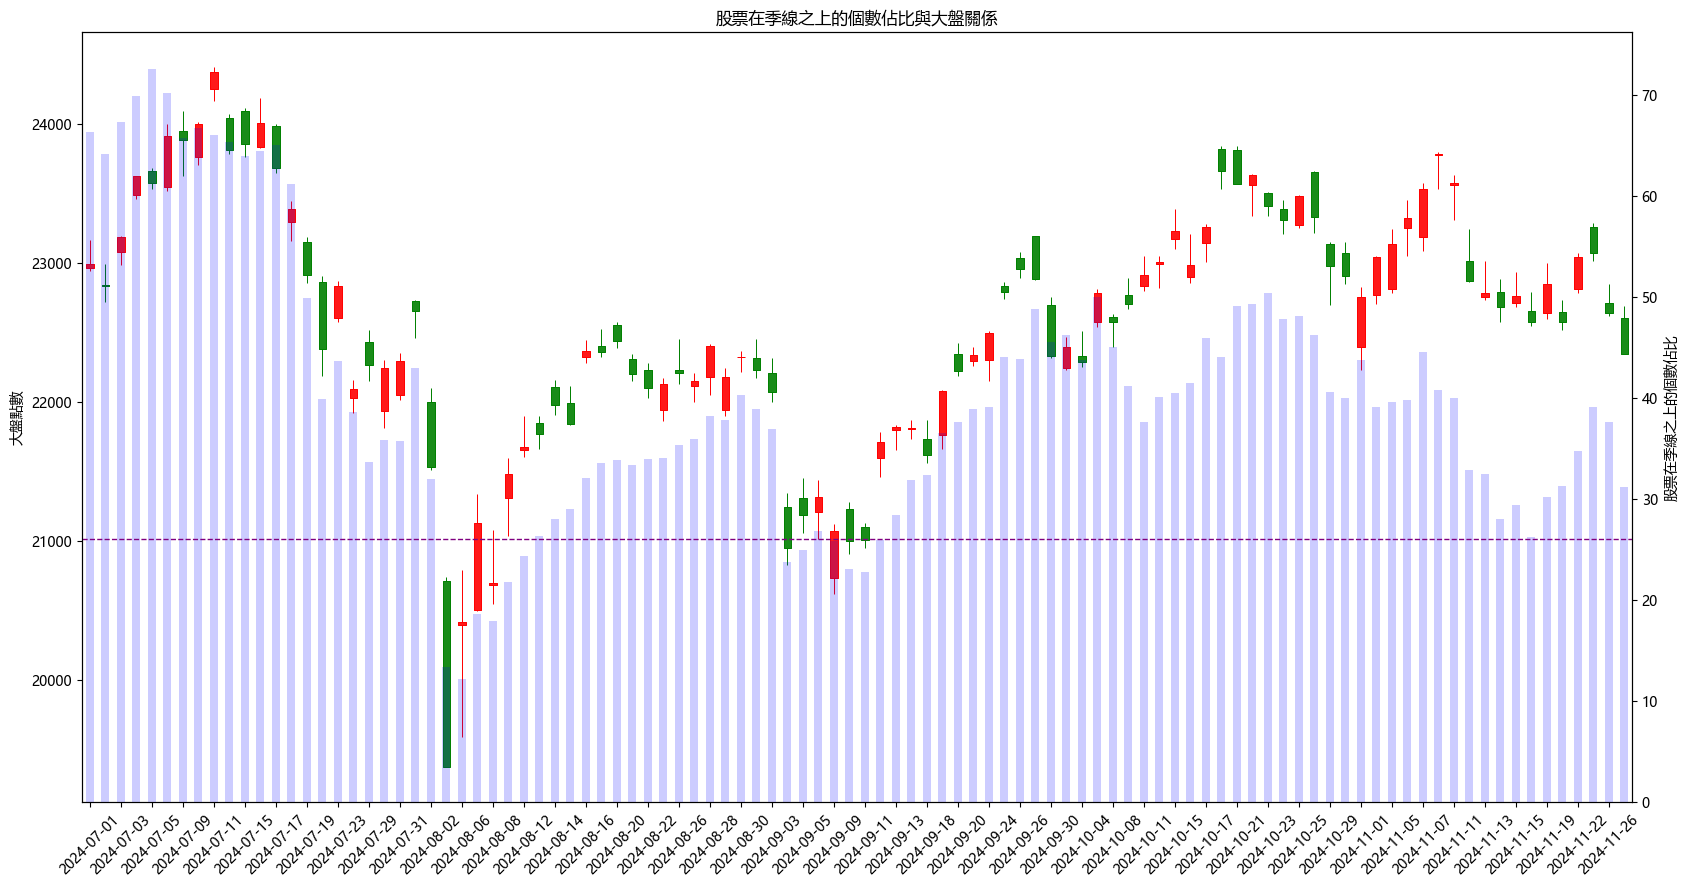

In [14]:
import mplfinance as mpf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

MA_count_forplot = MA_count_list.copy()
MA_count_forplot['Date'] = pd.to_datetime(MA_count_forplot['Date'])

MA_count_forplot.set_index('Date', inplace=True)
MA_count_forplot.index = MA_count_forplot.index.strftime('%Y-%m-%d')


tx_df_raw_100 = tx_df_forplot.tail(plot_size)
MA_count_forplot_100 = MA_count_forplot.tail(plot_size)


# 設置中文字體
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 使用微軟正黑體 (可根據系統字體選擇)
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題


# 假設你的 dataframe 含有必要的 OHLC 數據 (Open, High, Low, Close)
ohlc_data = tx_df_raw_100[['Open', 'High', 'Low', 'Close']]

# 自定義顏色樣式，上漲為紅色，下跌為綠色
my_color = mpf.make_marketcolors(up='red', down='green', edge='inherit', wick='inherit', volume='inherit')

# 自定義樣式
my_style = mpf.make_mpf_style(marketcolors=my_color)

# 設置主圖和次圖
fig, ax1 = plt.subplots(figsize=(20,10))

# 繪製蠟燭圖到 ax1，使用自定義的顏色樣式
mpf.plot(ohlc_data, type='candle', ax=ax1, volume=False, style=my_style)

# 設定 x 軸只顯示日期
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # 格式化日期顯示
ax1.xaxis.set_major_locator(mdates.AutoDateLocator())  # 自動設置日期間隔

# 旋轉 x 軸標籤以便更清楚顯示
plt.xticks(rotation=45)

# 創建一個共享 X 軸但有不同 Y 軸的次圖 ax2
ax2 = ax1.twinx()

# 繪製小外資的正負長條圖到 ax2
MA_count_forplot_100['MA60_count'].plot(kind='bar', color='blue', ax=ax2, alpha=0.2)  # 調整透明度以顯示蠟燭圖
# MA_count_forplot_100['MA20_count'].plot(kind='bar', color='blue', ax=ax2, alpha=0.2)  # 調整透明度以顯示蠟燭圖
# MA_count_forplot_100['MA60_count'].plot(kind='bar', color='red', ax=ax2, alpha=0.2)  # 調整透明度以顯示蠟燭圖
ax2.axhline(y=26, color='purple', linestyle='--', linewidth=1)

ax1.set_xticks(ax1.get_xticks()[::x_lab])  # 每隔5个标签显示一个

# 繪製 10MA 移動平均線到 ax1
#ax1.plot(tx_df_raw['10MA'].index, tx_df_raw['10MA'], label='10MA', color='blue', linewidth=2)

# 設定標題和軸標籤
plt.title('股票在季線之上的個數佔比與大盤關係')
ax1.set_ylabel('大盤點數')
ax2.set_ylabel('股票在季線之上的個數佔比')

# 顯示圖表
plt.show()


In [ ]:
MA_count_list

In [147]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

daily_putcall_list = pd.DataFrame()

# 目標 URL
url_tx = "https://www.taifex.com.tw/cht/3/pcRatio"


# POST 表單數據
payload_tx = {
    'queryStartDate': '2020/01/01',     # 查詢日期，格式為 YYYYMMDD
    'queryEndDate': '2020/01/01'     # 查詢日期，格式為 YYYYMMDD
}

# 發送 POST 請求
response = requests.post(url_tx, data=payload_tx, timeout=10)

# 檢查請求是否成功
if response.status_code == 200:
    # 解析 HTML
    soup = BeautifulSoup(response.text, 'html.parser')

    # 找到數據表格
    table = soup.find('table', class_='table_f')

    # 提取表格中的數據
    rows = []
    for row in table.find_all('tr')[1:]:  # 跳過表頭行
        cols = row.find_all('td')
        cols = [col.text.strip() for col in cols]
        rows.append(cols)

else:
    print(f"請求失敗，狀態碼：{response.status_code}")

print(len(rows))


# temp_list = pd.DataFrame({
#     '日期': [rows[0][0]], 
#     '賣權成交量': [rows[0][1].replace(',', '')],
#     '買權成交量': [rows[0][2].replace(',', '')],
#     '買賣權成交量比率': [rows[0][3]],
#     '賣權未平倉量': [rows[0][4].replace(',', '')],
#     '買權未平倉量': [rows[0][5].replace(',', '')],
#     '買賣權未平倉量比率': [rows[0][6]]
# })

# if not temp_list.empty:
#         daily_putcall_list = pd.concat([daily_putcall_list, temp_list], ignore_index=True)

# daily_putcall_list


0


In [141]:
int(daily_putcall_list['買權成交量'])

cols_to_numeric = ['賣權成交量', '買權成交量', '買賣權成交量比率', '賣權未平倉量','買權未平倉量','買賣權未平倉量比率']
daily_putcall_list[cols_to_numeric].apply(pd.to_numeric, errors='coerce')
daily_putcall_list[cols_to_numeric] = daily_putcall_list[cols_to_numeric].fillna(0)
daily_putcall_list

,日期,賣權成交量,買權成交量,買賣權成交量比率,賣權未平倉量,買權未平倉量,買賣權未平倉量比率
0,2020/1/2,552593,511342,108.07,237327,186703,127.11


In [23]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

daily_putcall_list = pd.DataFrame()

# 目標 URL
url_tx = "https://www.taifex.com.tw/cht/3/pcRatio"


for day in tx_df_raw['Date']:
    day = str(day)
    year = day[:4]
    month = day[5:7]
    day = day[8:]

    queryStartDate = year+"/"+month+"/"+day
    queryEndDate = year+"/"+month+"/"+day

    # POST 表單數據
    payload_tx = {
        'queryStartDate': queryStartDate,     # 查詢日期，格式為 YYYYMMDD
        'queryEndDate': queryEndDate,     # 查詢日期，格式為 YYYYMMDD
    }

    # 發送 POST 請求
    response = requests.post(url_tx, data=payload_tx, timeout=10)

    # 檢查請求是否成功
    if response.status_code == 200:
        # 解析 HTML
        soup = BeautifulSoup(response.text, 'html.parser')

        # 找到數據表格
        table = soup.find('table', class_='table_f')

        # 提取表格中的數據
        rows = []
        for row in table.find_all('tr')[1:]:  # 跳過表頭行
            cols = row.find_all('td')
            cols = [col.text.strip() for col in cols]
            rows.append(cols)

    else:
        print(f"請求失敗，狀態碼：{response.status_code}")




    temp_list = pd.DataFrame({
        '日期': [rows[0][0]], 
        '賣權成交量': [rows[0][1].replace(',', '')],
        '買權成交量': [rows[0][2].replace(',', '')],
        '買賣權成交量比率%': [rows[0][3]],
        '賣權未平倉量': [rows[0][4].replace(',', '')],
        '買權未平倉量': [rows[0][5].replace(',', '')],
        '買賣權未平倉量比率%': [rows[0][6]]
    })

    if not temp_list.empty:
            daily_putcall_list = pd.concat([daily_putcall_list, temp_list], ignore_index=True)

daily_putcall_list


,日期,賣權成交量,買權成交量,買賣權成交量比率%,賣權未平倉量,買權未平倉量,買賣權未平倉量比率%
0,2021/9/6,356407,344565,103.44,299154,232007,128.94
1,2021/9/7,375727,398162,94.37,318731,253279,125.84
2,2021/9/8,672625,701492,95.88,215750,183224,117.75
3,2021/9/9,322761,292585,110.31,261144,216671,120.53
4,2021/9/10,321912,266189,120.93,294188,213482,137.80
...,...,...,...,...,...,...,...
758,2024/10/22,336041,383730,87.57,146032,174177,83.84
759,2024/10/23,390696,526840,74.16,65954,85346,77.28
760,2024/10/24,189761,237082,80.04,93376,134601,69.37
761,2024/10/25,159875,187361,85.33,113957,145751,78.19


In [24]:
tx_df_raw.loc[:, '5MA'] = tx_df_raw['最後成交價'].rolling(5).mean()
tx_df_raw.loc[:, '8MA'] = tx_df_raw['最後成交價'].rolling(8).mean()
tx_df_raw.loc[:, '10MA'] = tx_df_raw['最後成交價'].rolling(10).mean()
tx_df_raw.loc[:, '20MA']= tx_df_raw['最後成交價'].rolling(20).mean()
tx_df_raw.loc[:, '60MA']= tx_df_raw['最後成交價'].rolling(60).mean()
tx_df_raw.loc[:, '240MA']= tx_df_raw['最後成交價'].rolling(240).mean()

tx_df_raw.loc[:, '5MApc_ratio'] = tx_df_raw['pc_ratio'].rolling(5).mean()
tx_df_raw.loc[:, '8MApc_ratio'] = tx_df_raw['pc_ratio'].rolling(8).mean()
tx_df_raw.loc[:, '10MApc_ratio'] = tx_df_raw['pc_ratio'].rolling(10).mean()
tx_df_raw.loc[:, '20MApc_ratio']= tx_df_raw['pc_ratio'].rolling(20).mean()
tx_df_raw.loc[:, '60MApc_ratio']= tx_df_raw['pc_ratio'].rolling(60).mean()
tx_df_raw.loc[:, '240MApc_ratio']= tx_df_raw['pc_ratio'].rolling(240).mean()

tx_df_raw = tx_df_raw.fillna(0)

daily_putcall = daily_putcall_list.copy()
tx_df_raw['pc_ratio'] = daily_putcall['買賣權未平倉量比率%']
tx_df_raw['pc_ratio'] = pd.to_numeric(tx_df_raw['pc_ratio'], errors='coerce')

tx_df_raw['pc_ratio'] = tx_df_raw['pc_ratio'] - 100
# 畫畫要畫幾天的資料
plot_size = 100

pc_ratio_std = tx_df_raw['pc_ratio'].std()
pc_ratio_std

KeyError: 'pc_ratio'

In [94]:
tx_df_raw[(tx_df_raw['pc_ratio'] < -30 ) & (tx_df_raw['最後成交價'] > tx_df_raw['240MA'])]
tx_df_raw['Date'] = pd.to_datetime(tx_df_raw['Date'])
tx_df_raw[tx_df_raw['Date'] == '2023-10-31']

,Date,契約,到期月份,開盤價,最高價,最低價,最後成交價,一般交易時段成交量,pc_ratio,5MA,8MA,10MA,20MA,60MA,240MA
522,2023-10-31,TX,202311,16180.0,16197.0,15973.0,15994.0,109000.0,-16.41,16145.8,16216.375,16261.5,16422.45,16524.966667,15823.020833


In [112]:
import numpy as np
tx_df_raw['hold'] = np.nan
condition_by = tx_df_raw['10MApc_ratio'] > 0
condition_sell = tx_df_raw['10MApc_ratio'] < 0

tx_df_raw.loc[condition_by, 'hold'] = 1
tx_df_raw.loc[condition_sell, 'hold'] = 0

tx_df_raw['hold'].ffill(inplace=True)
tx_df_raw['hold'] = tx_df_raw['hold'].fillna(0)

tx_df_raw[tx_df_raw['hold'] == 1]

C:\Users\USER\AppData\Local\Temp\ipykernel_2516\192408643.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  tx_df_raw['hold'].ffill(inplace=True)


,Date,契約,到期月份,開盤價,最高價,最低價,最後成交價,一般交易時段成交量,pc_ratio,5MA,...,20MA,60MA,240MA,5MApc_ratio,8MApc_ratio,10MApc_ratio,20MApc_ratio,60MApc_ratio,240MApc_ratio,hold
9,2021-09-17,TX,202110,17256.0,17395.0,17165.0,17298.0,117752.0,11.92,17366.2,...,0.00,0.000000,0.000000,21.968,23.24000,24.070,0.0000,0.000000,0.000000,1.0
10,2021-09-22,TX,202110,16835.0,16940.0,16751.0,16900.0,134553.0,6.40,17257.8,...,0.00,0.000000,0.000000,14.924,21.82125,21.816,0.0000,0.000000,0.000000,1.0
11,2021-09-23,TX,202110,17020.0,17130.0,16985.0,17080.0,99807.0,12.03,17181.6,...,0.00,0.000000,0.000000,9.898,20.75875,20.435,0.0000,0.000000,0.000000,1.0
12,2021-09-24,TX,202110,17191.0,17275.0,17170.0,17250.0,94226.0,11.40,17155.2,...,0.00,0.000000,0.000000,9.092,17.45875,19.800,0.0000,0.000000,0.000000,1.0
13,2021-09-27,TX,202110,17247.0,17344.0,17222.0,17292.0,94562.0,14.41,17164.0,...,0.00,0.000000,0.000000,11.232,14.05750,19.188,0.0000,0.000000,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,2024-10-17,TX,202411,23142.0,23277.0,23005.0,23256.0,75826.0,-8.72,23077.4,...,22581.60,22096.283333,20144.370833,11.152,10.19250,6.513,9.0510,1.306333,16.197708,1.0
756,2024-10-18,TX,202411,23820.0,23840.0,23527.0,23657.0,90326.0,-3.45,23226.4,...,22673.80,22100.850000,20175.216667,7.002,8.28625,8.243,8.3480,1.177667,16.205875,1.0
757,2024-10-21,TX,202411,23810.0,23836.0,23566.0,23567.0,53481.0,-11.92,23338.2,...,22771.20,22111.816667,20205.350000,0.546,6.54875,6.617,7.7975,1.067333,16.160542,1.0
758,2024-10-22,TX,202411,23560.0,23637.0,23332.0,23633.0,70377.0,-16.16,23419.8,...,22849.15,22132.716667,20235.662500,-9.600,3.02875,3.821,5.7975,1.254333,16.077000,1.0


In [131]:
import numpy as np
import warnings
# 計算訊號出來後隔天開盤直接買
# 出場訊號出來後 隔天開盤直接賣
# 忽略 FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

MA = '10MA'

tx_df_raw['hold'] = np.nan
condition_by = tx_df_raw['pc_ratio'] < -30
condition_sell = tx_df_raw['20MApc_ratio'] > 0

tx_df_raw.loc[condition_by, 'hold'] = 1
tx_df_raw.loc[condition_sell, 'hold'] = 0

tx_df_raw['hold'].ffill(inplace=True)
tx_df_raw['hold'] = tx_df_raw['hold'].fillna(0)

# 計算進出

day_list = tx_df_raw['Date'].unique().tolist()
earm_data1 = pd.DataFrame(columns=['buy_date','sell_date','buy_open','sell_open','earn'])

sell_date = pd.to_datetime("1911-01-01")  # Example Timestamp

for day in day_list:
        today_str = day.strftime('%Y-%m-%d')
        stock_df_today = tx_df_raw[tx_df_raw['Date'] == today_str].copy() 

        if((stock_df_today['hold'].iloc[0] == 1) & ( pd.to_datetime(today_str) > sell_date)): # 符合條件第一天

                buy_close = tx_df_raw[tx_df_raw['Date'] > today_str]['開盤價'].iloc[0] 
                buy_date = tx_df_raw[tx_df_raw['Date'] > today_str]['Date'].iloc[0] 

                
                sell_date = tx_df_raw[(tx_df_raw['hold'] == 0) & (tx_df_raw['Date'] > today_str)]['Date'].iloc[0] 
                sell_date = pd.to_datetime(sell_date)
                sell_open = tx_df_raw[(tx_df_raw['Date'] > sell_date)]['開盤價'].iloc[0] 
                
                earn = sell_open - buy_close

                result_df = pd.DataFrame({
                        'buy_date': [buy_date],
                        'sell_date': [sell_date],
                        'buy_open': [buy_close],
                        'sell_open': [sell_open],
                        'earn': [earn]
                        })

                # 删除全为NA的列，避免可能出现的警告
                result_df.dropna(axis=1, how='all', inplace=True)

                if not result_df.empty:
                        earm_data1 = pd.concat([earm_data1, result_df], ignore_index=True)


earm_data1

,buy_date,sell_date,buy_open,sell_open,earn
0,2022-06-23,2023-01-16,15059.0,14923.0,-136.0
1,2023-08-15,2023-09-14,16471.0,16848.0,377.0
2,2024-08-06,2024-09-02,20395.0,22205.0,1810.0


In [125]:
earm_data1['earn'].sum()

5556.0

In [20]:
pc_ratio_forplot = pc_ratio_raw.copy()
pc_ratio_forplot['Date'] = pd.to_datetime(pc_ratio_forplot['Date'])

pc_ratio_forplot.set_index('Date', inplace=True)
pc_ratio_forplot.index = pc_ratio_forplot.index.strftime('%Y-%m-%d')
pc_ratio_forplot['買賣權未平倉量比率'] = pc_ratio_forplot['買賣權未平倉量比率'] - 100


tx_df_raw_100 = tx_df_forplot.tail(plot_size)
pc_ratio_forplot_100 = pc_ratio_forplot.tail(plot_size)

pc_ratio_forplot_100

,賣權成交量,買權成交量,買賣權成交量比率,賣權未平倉量,買權未平倉量,買賣權未平倉量比率
Date,,,,,,
2021-10-26,329606,307158,107.31,234714,196544,19.42
2021-10-27,403093,468497,86.04,135474,125095,8.30
2021-10-28,173373,172719,100.38,175239,159786,9.67
2021-10-29,226198,255806,88.43,199549,188147,6.06
2021-11-01,267164,262510,101.77,235144,207983,13.06
...,...,...,...,...,...,...
2024-11-21,191834,231640,82.82,102062,119417,-14.53
2024-11-22,323344,320147,101.00,139962,128797,8.67
2024-11-25,246856,242709,101.71,157494,154804,1.74


In [26]:
pc_ratio_raw

,Date,賣權成交量,買權成交量,買賣權成交量比率,賣權未平倉量,買權未平倉量,買賣權未平倉量比率
0,2021-01-04,409683,362995,112.86,291020,209950,138.61
1,2021-01-05,521319,434658,119.94,340035,231535,146.86
2,2021-01-06,1150550,943431,121.95,215027,168662,127.49
3,2021-01-07,433433,379735,114.14,317416,206419,153.77
4,2021-01-08,433851,467386,92.82,350448,236988,147.88
...,...,...,...,...,...,...,...
941,2024-11-21,191834,231640,82.82,102062,119417,85.47
942,2024-11-22,323344,320147,101.00,139962,128797,108.67
943,2024-11-25,246856,242709,101.71,157494,154804,101.74
944,2024-11-26,292849,393180,74.48,160403,187900,85.37


In [29]:
# tx_df_raw.loc[:, '5MA'] = tx_df_raw['最後成交價'].rolling(5).mean()
# tx_df_raw.loc[:, '8MA'] = tx_df_raw['最後成交價'].rolling(8).mean()
# tx_df_raw.loc[:, '10MA'] = tx_df_raw['最後成交價'].rolling(10).mean()
# tx_df_raw.loc[:, '20MA']= tx_df_raw['最後成交價'].rolling(20).mean()
# tx_df_raw.loc[:, '60MA']= tx_df_raw['最後成交價'].rolling(60).mean()
# tx_df_raw.loc[:, '240MA']= tx_df_raw['最後成交價'].rolling(240).mean()

pc_ratio_raw.loc[:, '5MApc_ratio'] = pc_ratio_raw['買賣權未平倉量比率'].rolling(5).mean()
pc_ratio_raw.loc[:, '8MApc_ratio'] = pc_ratio_raw['買賣權未平倉量比率'].rolling(8).mean()
pc_ratio_raw.loc[:, '10MApc_ratio'] = pc_ratio_raw['買賣權未平倉量比率'].rolling(10).mean()
pc_ratio_raw.loc[:, '20MApc_ratio']= pc_ratio_raw['買賣權未平倉量比率'].rolling(20).mean()
pc_ratio_raw.loc[:, '60MApc_ratio']= pc_ratio_raw['買賣權未平倉量比率'].rolling(60).mean()
pc_ratio_raw.loc[:, '240MApc_ratio']= pc_ratio_raw['買賣權未平倉量比率'].rolling(240).mean()

pc_ratio_raw = pc_ratio_raw.fillna(0)


pc_ratio_forplot = pc_ratio_raw.copy()
pc_ratio_forplot['Date'] = pd.to_datetime(pc_ratio_forplot['Date'])

pc_ratio_forplot.set_index('Date', inplace=True)
pc_ratio_forplot.index = pc_ratio_forplot.index.strftime('%Y-%m-%d')
pc_ratio_forplot['買賣權未平倉量比率'] = pc_ratio_forplot['買賣權未平倉量比率'] - 100


tx_df_raw_100 = tx_df_forplot.tail(plot_size)
pc_ratio_forplot_100 = pc_ratio_forplot.tail(plot_size)

pc_ratio_forplot_100
# daily_putcall = daily_putcall_list.copy()
# tx_df_raw['pc_ratio'] = daily_putcall['買賣權未平倉量比率%']
# tx_df_raw['pc_ratio'] = pd.to_numeric(tx_df_raw['pc_ratio'], errors='coerce')

# tx_df_raw['pc_ratio'] = tx_df_raw['pc_ratio'] - 100
# # 畫畫要畫幾天的資料
# plot_size = 100

# pc_ratio_std = tx_df_raw['pc_ratio'].std()
# pc_ratio_std

,賣權成交量,買權成交量,買賣權成交量比率,賣權未平倉量,買權未平倉量,買賣權未平倉量比率,5MApc_ratio,8MApc_ratio,10MApc_ratio,20MApc_ratio,60MApc_ratio,240MApc_ratio
Date,,,,,,,,,,,,
2021-10-26,329606,307158,107.31,234714,196544,19.42,112.390,110.74375,108.702,103.0325,110.537500,0.000000
2021-10-27,403093,468497,86.04,135474,125095,8.30,109.710,110.12250,109.393,103.2705,110.598000,0.000000
2021-10-28,173373,172719,100.38,175239,159786,9.67,109.880,111.15875,110.392,104.2315,110.457833,0.000000
2021-10-29,226198,255806,88.43,199549,188147,6.06,110.000,110.74750,109.671,104.4950,110.228000,0.000000
2021-11-01,267164,262510,101.77,235144,207983,13.06,111.302,109.66750,110.839,105.9460,110.220333,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-21,191834,231640,82.82,102062,119417,-14.53,87.568,87.74250,92.918,85.9265,98.073167,114.022792
2024-11-22,323344,320147,101.00,139962,128797,8.67,93.624,89.12750,92.744,87.4960,98.110667,114.039500
2024-11-25,246856,242709,101.71,157494,154804,1.74,96.708,91.45750,91.235,89.1145,98.120833,114.022958


C:\Users\USER\AppData\Local\Temp\ipykernel_9432\1223259742.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tx_df_raw_100['Date'] = pd.to_datetime(tx_df_raw_100['Date'])


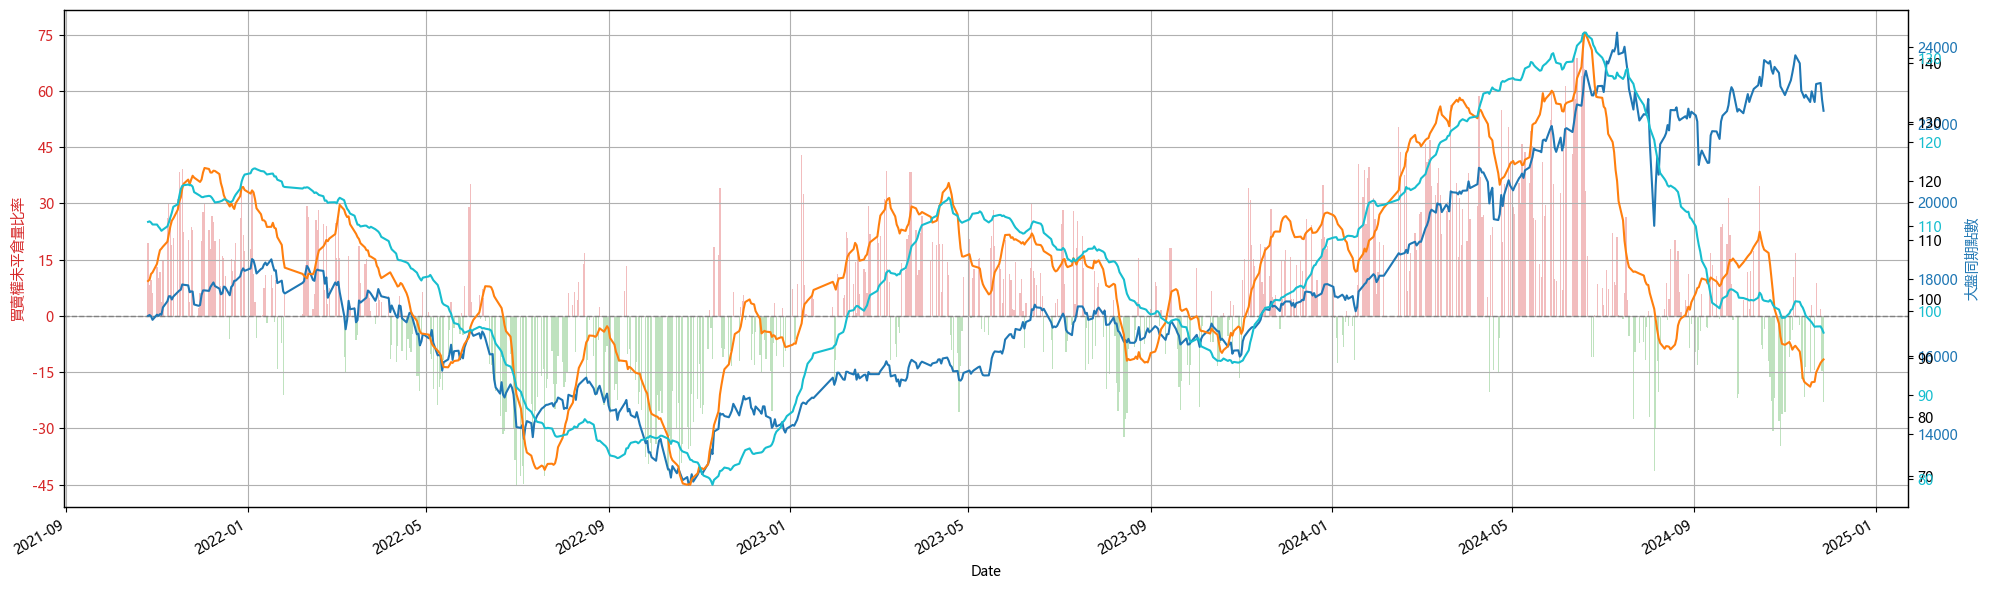

In [35]:
import matplotlib.pyplot as plt
# warnings.simplefilter(action='ignore', category=FutureWarning)
from matplotlib.ticker import MaxNLocator

plot_size = 750
tx_df_raw_100 = tx_df_raw.tail(plot_size)

# 設置中文字體
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 使用微軟正黑體 (可根據系統字體選擇)
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題

# 将 'Date' 列转换为 datetime 类型
tx_df_raw_100['Date'] = pd.to_datetime(tx_df_raw_100['Date'])
# 假設 'Date' 已經是日期格式
fig, ax1 = plt.subplots(figsize=(20, 6))

# 第一條線 - 最後成交價
ax1.set_xlabel('Date')
ax1.set_ylabel('買賣權未平倉量比率', color='tab:red')
# Define colors based on the threshold (100)
colors = ['tab:red' if value > 0 else 'tab:green' for value in pc_ratio_forplot_100['買賣權未平倉量比率']]
# Plot as a bar chart with conditional colors
ax1.bar(tx_df_raw_100['Date'], pc_ratio_forplot_100['買賣權未平倉量比率'], color=colors , alpha=0.3)
# Draw a horizontal line at y=100 for the threshold
ax1.axhline(0, color='gray', linestyle='--', linewidth=1)
# Set tick parameters for the y-axis
ax1.tick_params(axis='y', labelcolor='tab:red')

# 開啟網格
ax1.grid(True)
# 調整 Y 軸間距 (設定更多標籤)
ax1.yaxis.set_major_locator(MaxNLocator(prune=None, nbins=10))  # 增加 Y 軸標籤數量

# 建立第二個Y軸
ax2 = ax1.twinx()  
ax2.set_ylabel('大盤同期點數', color='tab:blue')  # 可以根據需要調整標籤
ax2.plot(tx_df_raw_100['Date'], tx_df_raw_100['最後成交價'], color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# # 調整第二個 Y 軸間距 (同樣設定更多標籤)
# ax2.yaxis.set_major_locator(MaxNLocator(prune=None, nbins=10))  # 增加 Y 軸標籤數量

# # 建立第二個Y軸
a3 = ax1.twinx()  
a3.plot(tx_df_raw_100['Date'], pc_ratio_forplot_100['20MApc_ratio'], color='tab:orange')

a4 = ax1.twinx()  
a4.plot(tx_df_raw_100['Date'], pc_ratio_forplot_100['60MApc_ratio'], color='tab:cyan')
a4.tick_params(axis='y', labelcolor='tab:cyan')


# 旋轉日期標籤
fig.autofmt_xdate()

# 顯示圖表
fig.tight_layout()
plt.show()


In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

daily_tx_data = pd.DataFrame()

# 目標 URL
url_tx = "https://www.taifex.com.tw/cht/3/pcRatio"
queryStartDate = '2024/09/03'
queryEndDate = '2024/10/03'

# POST 表單數據
payload_tx = {
    'queryStartDate': queryStartDate,     # 查詢日期，格式為 YYYYMMDD
    'queryEndDate': queryEndDate,     # 查詢日期，格式為 YYYYMMDD
}

# 發送 POST 請求
response = requests.post(url_tx, data=payload_tx, timeout=10)

# 檢查請求是否成功
if response.status_code == 200:
    # 解析 HTML
    soup = BeautifulSoup(response.text, 'html.parser')

    # 找到數據表格
    table = soup.find('table', class_='table_f')

    # 提取表格中的數據
    rows = []
    for row in table.find_all('tr')[1:]:  # 跳過表頭行
        cols = row.find_all('td')
        cols = [col.text.strip() for col in cols]
        rows.append(cols)

else:
    print(f"請求失敗，狀態碼：{response.status_code}")

if (rows[0][0] == 'TX'):
    daily_tx_data = pd.DataFrame({
        'Date': [queryDate], 
        '契約': [rows[0][0]],
        '到期月份': [rows[0][1]],
        '開盤價': [rows[0][2]],
        '最高價': [rows[0][3]],
        '最低價': [rows[0][4]],
        '最後成交價': [rows[0][5]],
        '一般交易時段成交量': [rows[0][9]]
    })

daily_tx_data


In [28]:
import requests
import re
from bs4 import BeautifulSoup
import pandas as pd

tif_investors_data = pd.DataFrame()

# 設定目標 URL 和表單提交參數
url_top5 = "https://www.taifex.com.tw/cht/3/largeTraderFutQry"
queryDate = '2024/09/04'

# 表單數據
payload_top5 = {
    'queryDate': queryDate,               
    'contractId': 'TX'  # 臺股期貨+小臺指期貨/4+臺指摩根期貨/20
}


tx_top5 = 0
# 發送 POST 請求
response = requests.post(url_top5, data=payload_top5)

# 確認請求是否成功
if response.status_code == 200:
    # 解析 HTML 結果
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # 提取目標表格
    table = soup.find('table', class_='table_f')

    # 解析表格內容
    rows = []
    for row in table.find_all('tr')[1:]:  # 跳過標題行
        cols = row.find_all('td')
        cols = [col.text.strip() for col in cols]
        rows.append(cols)

else:
    print(f"請求失敗，狀態碼：{response.status_code}")

if((rows[2][0] == '臺股期貨(TX+MTX/4+TMF/20)') & (rows[4][0] == '所有契約')):
    text = rows[4][1]
    match = re.search(r'\(([\d,]+)\)', text)
    # 如果找到匹配，去除逗號並取出數字
    if match:
        tx_top5 = match.group(1).replace(',', '')


# 設定目標 URL 和表單提交的參數（包括日期）
url_tif = "https://www.taifex.com.tw/cht/3/futContractsDate"

# 你可以更改日期來獲取不同天數的數據
payload_tif = {
    'queryDate': queryDate,  # 若要查詢特定日期，填入日期
    'commodity_id': 'TXF'  # TX 表示臺股期貨
}


# 發送 POST 請求
response = requests.post(url_tif, data=payload_tif)

# 檢查請求是否成功
if response.status_code == 200:
    # 解析 HTML
    soup = BeautifulSoup(response.text, 'html.parser')
    trust_data = []    
    # 尋找數據表格

    # 尋找數據表格
    table = soup.find('table', class_='table_f')
    if table:
        rows = table.find_all("tr")[1:]  # 忽略表头
        for row in rows:
            columns = row.find_all("td")
            row_data = [col.text.strip() for col in columns]
            if(len(row_data)!=0):
                trust_data.append(row_data)

    if ( (trust_data[0][1] == '臺股期貨') &(trust_data[0][2] == '自營商') & (trust_data[1][0] == '投信') & (trust_data[2][0] == '外資')):

        tif_investors_data = pd.DataFrame({
            'Date': [queryDate], 
            '自營未平倉餘額口數': [trust_data[0][13].replace(',', '')],
            '自營未平倉餘額金額': [trust_data[0][14].replace(',', '')],
            '投信未平倉餘額口數': [trust_data[1][11].replace(',', '')],
            '投信未平倉餘額金額': [trust_data[1][12].replace(',', '')],
            '外資未平倉餘額口數': [trust_data[2][11].replace(',', '')],
            '外資未平倉餘額金額': [trust_data[2][12].replace(',', '')],
            '前五大交易人合計': [tx_top5]
    })
    
else:
    print(f"請求失敗，狀態碼：{response.status_code}")


tif_investors_data

,Date,自營未平倉餘額口數,自營未平倉餘額金額,投信未平倉餘額口數,投信未平倉餘額金額,外資未平倉餘額口數,外資未平倉餘額金額,前五大交易人合計
0,2024/09/04,1203,5036338,22426,93920072,-30917,-129479963,33213


In [127]:
# 爬蟲選擇權未平倉 10大法柔 買權 

import requests
import re
from bs4 import BeautifulSoup
import pandas as pd

# 設定目標 URL 和表單提交參數
url_top5 = "https://www.taifex.com.tw/cht/3/largeTraderOptQry"

# 表單數據
payload_top5 = {
    'queryDate': '2024/09/06',               
    'contractId': 'TXO'  # 臺股期貨+小臺指期貨/4+臺指摩根期貨/20
}


tx_top5_buy = 0
tx_top5_sell = 0
# 發送 POST 請求
response = requests.post(url_top5, data=payload_top5)

# 確認請求是否成功
if response.status_code == 200:
    # 解析 HTML 結果
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # 提取目標表格
    table = soup.find('table', class_='table_f')

    # 解析表格內容
    rows = []
    for row in table.find_all('tr')[1:]:  # 跳過標題行
        cols = row.find_all('td')
        cols = [col.text.strip() for col in cols]
        rows.append(cols)

else:
    print(f"請求失敗，狀態碼：{response.status_code}")

text1 = rows[3][3] # 買方
match1 = re.match(r'[\d,]+', text1).group()
# 如果找到匹配，去除逗號並取出數字
if match1:
    tx_top5_buy = match1.replace(',', '')
tx_top5_buy


# if((rows[2][0] == '臺股期貨(TX+MTX/4+TMF/20)') & (rows[4][0] == '所有契約')):
#     text1 = rows[4][1] # 買方
#     match1 = re.search(r'\(([\d,]+)\)', text1)
#     # 如果找到匹配，去除逗號並取出數字
#     if match1:
#         tx_top5_buy = match1.group(1).replace(',', '')
    
#     text2 = rows[4][5] # 賣方
#     match2 = re.search(r'\(([\d,]+)\)', text2)
#     # 如果找到匹配，去除逗號並取出數字
#     if match2:
#         tx_top5_sell = match2.group(1).replace(',', '')
    

'28249'

In [42]:
import requests
import re
from bs4 import BeautifulSoup
import pandas as pd

# 設定目標 URL 和表單提交參數
url_top5 = "https://www.taifex.com.tw/cht/3/largeTraderFutQry"

# 表單數據
payload_top5 = {
    'queryDate': '2024/09/04',               
    'contractId': 'TX'  # 臺股期貨+小臺指期貨/4+臺指摩根期貨/20
}


tx_top5_buy = 0
tx_top5_sell = 0
# 發送 POST 請求
response = requests.post(url_top5, data=payload_top5)

# 確認請求是否成功
if response.status_code == 200:
    # 解析 HTML 結果
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # 提取目標表格
    table = soup.find('table', class_='table_f')

    # 解析表格內容
    rows = []
    for row in table.find_all('tr')[1:]:  # 跳過標題行
        cols = row.find_all('td')
        cols = [col.text.strip() for col in cols]
        rows.append(cols)

else:
    print(f"請求失敗，狀態碼：{response.status_code}")

if((rows[2][0] == '臺股期貨(TX+MTX/4+TMF/20)') & (rows[4][0] == '所有契約')):
    text1 = rows[4][1] # 買方
    match1 = re.search(r'\(([\d,]+)\)', text1)
    # 如果找到匹配，去除逗號並取出數字
    if match1:
        tx_top5_buy = match1.group(1).replace(',', '')
    
    text2 = rows[4][5] # 賣方
    match2 = re.search(r'\(([\d,]+)\)', text2)
    # 如果找到匹配，去除逗號並取出數字
    if match2:
        tx_top5_sell = match2.group(1).replace(',', '')
    

In [4]:
tif_investors_df_raw
# 五大特定淨部位
top5_sp = tif_investors_df_raw['買方前五大交易人合計'] - tif_investors_df_raw['賣方前五大交易人合計']
# 大外資 = 五大減投信 (投信應該依定會進去前五大)
big_foreign = top5_sp - tif_investors_df_raw['投信未平倉餘額口數']
# 小外資
small_foreign = tif_investors_df_raw['外資未平倉餘額口數'] - big_foreign

tif_investors_df_raw['大外資']  = big_foreign
tif_investors_df_raw['小外資']  = small_foreign



# 将 'Date' 列转换为 datetime 类型
tif_investors_df_raw['Date'] = pd.to_datetime(tif_investors_df_raw['Date'])
tx_df_raw['Date'] = pd.to_datetime(tx_df_raw['Date'])  # 假设你有一个 Date 列


tx_df_raw.loc[:, '5MA'] = tx_df_raw['最後成交價'].rolling(5).mean()
tx_df_raw.loc[:, '8MA'] = tx_df_raw['最後成交價'].rolling(8).mean()
tx_df_raw.loc[:, '10MA'] = tx_df_raw['最後成交價'].rolling(10).mean()
tx_df_raw.loc[:, '20MA']= tx_df_raw['最後成交價'].rolling(20).mean()
tx_df_raw.loc[:, '60MA']= tx_df_raw['最後成交價'].rolling(60).mean()
tx_df_raw.loc[:, '240MA']= tx_df_raw['最後成交價'].rolling(240).mean()

tx_df_raw = tx_df_raw.fillna(0)

# tx_df_raw = tx_df_raw.tail(100)
# tif_investors_df_raw = tif_investors_df_raw.tail(100)

In [ ]:
import mplfinance as mpf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 設置中文字體
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 使用微軟正黑體 (可根據系統字體選擇)
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題

# 假設你的 dataframe 含有必要的 OHLC 數據 (Open, High, Low, Close)
ohlc_data = tx_df_raw_100[['Open', 'High', 'Low', 'Close']]

# 自定義顏色樣式，上漲為紅色，下跌為綠色
my_color = mpf.make_marketcolors(up='red', down='green', edge='inherit', wick='inherit', volume='inherit')

# 自定義樣式
my_style = mpf.make_mpf_style(marketcolors=my_color)
my_addplot_ma = mpf.make_addplot(tx_df_raw_100['10MA'], color='blue')

# 創建長條圖的附加圖
my_addplot_investors = mpf.make_addplot(tif_investors_df_raw_100['小外資'], 
                                         type='bar', 
                                         color=['red' if v >= 0 else 'green' for v in tif_investors_df_raw_100['小外資']],
                                         alpha=0.3)

# 繪製蠟燭圖並添加 10MA 和小外資長條圖
mpf.plot(ohlc_data, 
         type='candle', 
         style=my_style, 
         addplot=[my_addplot_ma, my_addplot_investors],
         volume=False,
         title='股票蠟燭圖及小外資與10MA',
         ylabel='股票價格 (Open, High, Low, Close)',
         ylabel_lower='小外資',
         figratio=(20, 20), 
         datetime_format='%Y-%m-%d',
         xrotation=45)

# 顯示圖表
plt.show()


In [192]:
import numpy as np
import warnings
# 計算訊號出來後隔天開盤直接買
# 出場訊號出來後 隔天開盤直接賣
# 忽略 FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

MA = '10MA'

tx_df_raw = tx_df_raw[tx_df_raw[MA] != 0]
# tx_df_raw[tx_df_raw['最後成交價'] >= tx_df_raw['10MA']]
tif_investors_df_raw['小外資變化'] = tif_investors_df_raw['小外資'].diff(1)
tif_investors_df_raw.dropna()

# 使用 'Date' 欄位進行內部連接
merged_df = pd.merge(tif_investors_df_raw, tx_df_raw, on='Date', how='inner')

merged_df['hold'] = np.nan

condition_buy = ((merged_df['最後成交價'] >=  merged_df[MA]) & (merged_df['小外資變化'] > 0))

condition_sell = (merged_df['最後成交價'] <  merged_df[MA])

merged_df.loc[condition_buy, 'hold'] = 1
merged_df.loc[condition_sell, 'hold'] = 0

merged_df['hold'].ffill(inplace=True)
merged_df['hold'] = merged_df['hold'].fillna(0)

# 計算進出

day_list = merged_df['Date'].unique().tolist()
earm_data1 = pd.DataFrame(columns=['buy_date','sell_date','buy_open','sell_open','earn'])

sell_date = pd.to_datetime("1911-01-01")  # Example Timestamp

for day in day_list:
        today_str = day.strftime('%Y-%m-%d')
        stock_df_today = merged_df[merged_df['Date'] == today_str].copy() 

        if((stock_df_today['hold'].iloc[0] == 1) & ( pd.to_datetime(today_str) > sell_date)): # 符合條件第一天

                close = merged_df[merged_df['Date'] > today_str]['最後成交價'].iloc[0] 
                ma10 = merged_df[merged_df['Date'] > today_str][MA].iloc[0] 

                if (close >=  ma10):
                        #隔天收盤要站上再買進
                        buy_close = merged_df[merged_df['Date'] > today_str]['最後成交價'].iloc[0] 
                        buy_date = merged_df[merged_df['Date'] > today_str]['Date'].iloc[0] 


                        #跌破ma當天
                        sell_open = merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > today_str)]['最後成交價'].iloc[0] 
                        sell_date = merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > today_str)]['Date'].iloc[0] 
                        sell_date = pd.to_datetime(sell_date)

                        earn = sell_open - buy_close

                        result_df = pd.DataFrame({
                                'buy_date': [buy_date],
                                'sell_date': [sell_date],
                                'buy_open': [buy_close],
                                'sell_open': [sell_open],
                                'earn': [earn]
                                })

                        # 删除全为NA的列，避免可能出现的警告
                        result_df.dropna(axis=1, how='all', inplace=True)

                        if not result_df.empty:
                                earm_data1 = pd.concat([earm_data1, result_df], ignore_index=True)

        
# earm_data1['cumsum'] = earm_data1['earn'].cumsum()
# earm_data1



===大盤累積====
5421.0
===外資小兒法累積====
5092.0
===進出次數====
40
===第一次買進===
2021-10-18 00:00:00
===最後一次賣出===
2024-08-27 00:00:00


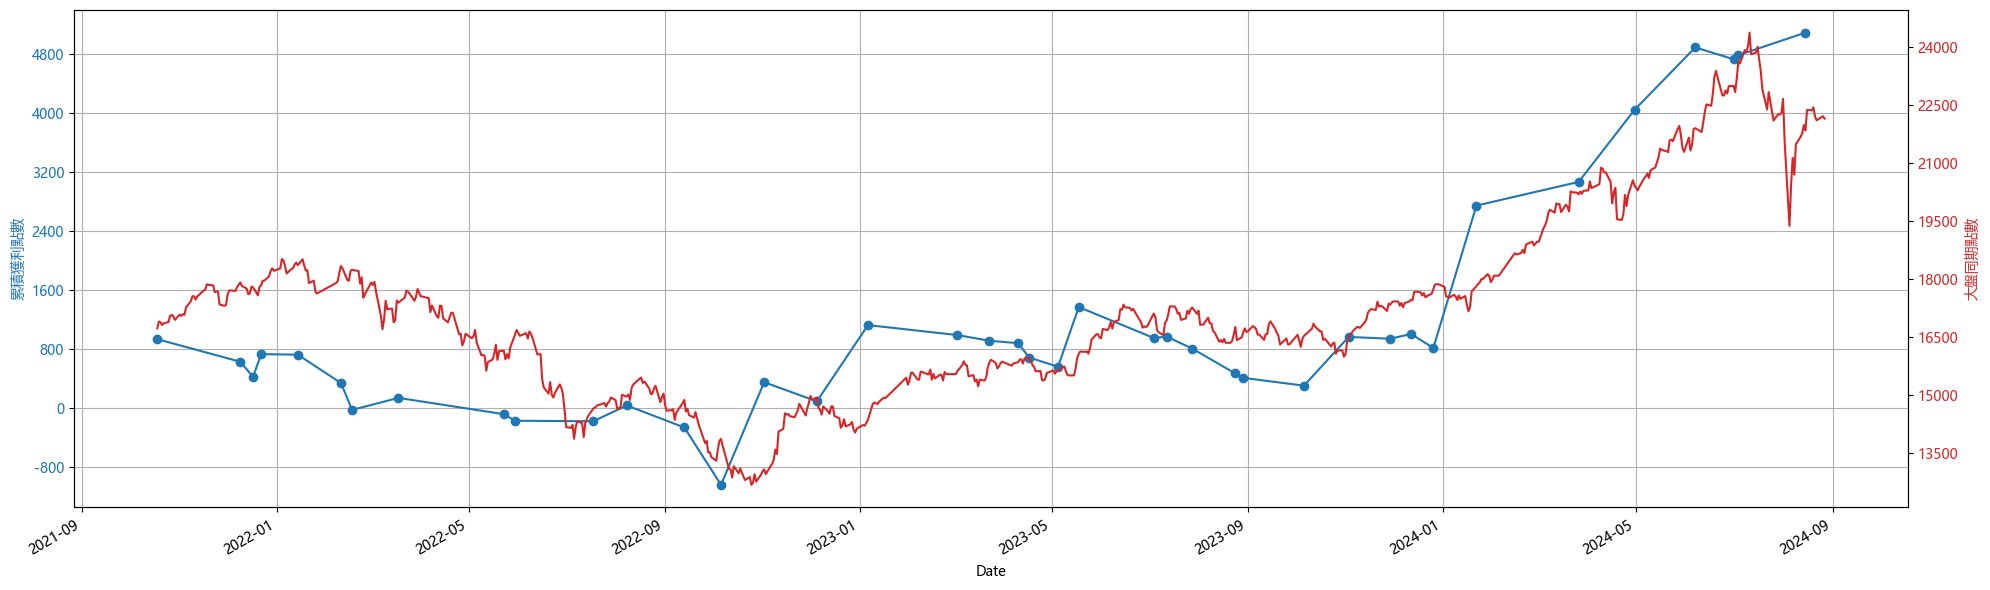

In [193]:
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore', category=FutureWarning)
from matplotlib.ticker import MaxNLocator

# 同期大盤資料 
tx_df = merged_df[( merged_df['Date'] >=  earm_data1['buy_date'].iloc[0]) & (merged_df['Date'] <= earm_data1['sell_date'].iloc[-1])]

print('===大盤累積====')
print(tx_df['最後成交價'].iloc[-1] - tx_df['最後成交價'].iloc[0])

print('===外資小兒法累積====')
print(earm_data1['earn'].cumsum().iloc[-1])

print('===進出次數====')
print(len(earm_data1))

print('===第一次買進===')
print(earm_data1['buy_date'].iloc[0])

print('===最後一次賣出===')
print(earm_data1['sell_date'].iloc[-1])

# 設置中文字體
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 使用微軟正黑體 (可根據系統字體選擇)
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題


# 假設 'Date' 已經是日期格式
fig, ax1 = plt.subplots(figsize=(20, 6))

# 第一條線 - 最後成交價
ax1.set_xlabel('Date')
ax1.set_ylabel('累積獲利點數', color='tab:blue')
ax1.plot(earm_data1['buy_date'], earm_data1['earn'].cumsum(), color='tab:blue', marker='o')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# 開啟網格
ax1.grid(True)
# 調整 Y 軸間距 (設定更多標籤)
ax1.yaxis.set_major_locator(MaxNLocator(prune=None, nbins=10))  # 增加 Y 軸標籤數量

# 建立第二個Y軸
ax2 = ax1.twinx()  
ax2.set_ylabel('大盤同期點數', color='tab:red')  # 可以根據需要調整標籤
ax2.plot(tx_df['Date'], tx_df['最後成交價'], color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# 調整第二個 Y 軸間距 (同樣設定更多標籤)
ax2.yaxis.set_major_locator(MaxNLocator(prune=None, nbins=10))  # 增加 Y 軸標籤數量

# 旋轉日期標籤
fig.autofmt_xdate()

# 顯示圖表
fig.tight_layout()
plt.show()


In [28]:
# merged_df[(merged_df['Date'] >= '2024-07-01') & (merged_df['Date'] <= '2024-07-10')][['Date', '開盤價' ,'最後成交價','小外資變化' ,'10MA','hold']]
#merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > '2024-06-28')][['Date', '開盤價' ,'最後成交價','小外資變化' ,'10MA','hold']]

直接看 大盤十日線 十日以上買 以下賣 做空多看季線 季線以上不做空

In [124]:
import numpy as np
import warnings
# 如果單純看10MA不管小外資 
# 忽略 FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

MA = '10MA'

tx_df_raw = tx_df_raw[tx_df_raw[MA] != 0]
# tx_df_raw[tx_df_raw['最後成交價'] >= tx_df_raw['10MA']]
tif_investors_df_raw['小外資變化'] = tif_investors_df_raw['小外資'].diff(1)
tif_investors_df_raw.dropna()

# 使用 'Date' 欄位進行內部連接
merged_df = pd.merge(tif_investors_df_raw, tx_df_raw, on='Date', how='inner')

merged_df['hold'] = np.nan

condition_buy = ((merged_df['最後成交價'] <=  merged_df[MA]) & (merged_df['最後成交價'] <=  merged_df['60MA']))  # 多加一個季線以下

condition_sell = (merged_df['最後成交價'] >  merged_df[MA])

merged_df.loc[condition_buy, 'hold'] = 1
merged_df.loc[condition_sell, 'hold'] = 0

merged_df['hold'].ffill(inplace=True)
merged_df['hold'] = merged_df['hold'].fillna(0)

# 計算進出

day_list = merged_df['Date'].unique().tolist()
earm_data2_sell = pd.DataFrame(columns=['today_str','buy_date','sell_date','buy_open','sell_open','earn','type'])

sell_date = pd.to_datetime("1911-01-01")  # Example Timestamp

for day in day_list:
        today_str = day.strftime('%Y-%m-%d')
        stock_df_today = merged_df[merged_df['Date'] == today_str].copy() 

        if((stock_df_today['hold'].iloc[0] == 1) & ( pd.to_datetime(today_str) > sell_date)): # 符合條件第一天
                
                buy_df = merged_df[merged_df['Date'] == today_str]

                if (len(buy_df) > 0):
                        # 收盤跌破十日線直接開空 不囉嗦
                        buy_open = merged_df[merged_df['Date'] == today_str]['最後成交價'].iloc[0] 
                        buy_date = merged_df[merged_df['Date'] == today_str]['Date'].iloc[0] 

                        sell_df = merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > today_str)]
                        
                        if (len(sell_df) >1 ):
                                
                                #跌破ma當天
                                sell_open = merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > today_str)]['最後成交價'].iloc[0] 
                                sell_date = merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > today_str)]['Date'].iloc[0] 
                                sell_date = pd.to_datetime(sell_date)

                                earn = buy_open - sell_open 

                                result_df = pd.DataFrame({
                                        'today_str' : [today_str],
                                        'buy_date': [buy_date],
                                        'sell_date': [sell_date],
                                        'buy_open': [buy_open],
                                        'sell_open': [sell_open],
                                        'earn': [earn],
                                        'type' : ['s']
                                        })

                                # 删除全为NA的列，避免可能出现的警告
                                result_df.dropna(axis=1, how='all', inplace=True)

                                if not result_df.empty:
                                        earm_data2_sell = pd.concat([earm_data2_sell, result_df], ignore_index=True)


# 做多 ==========================================================================================================================

tx_df_raw = tx_df_raw[tx_df_raw[MA] != 0]
# tx_df_raw[tx_df_raw['最後成交價'] >= tx_df_raw['10MA']]
tif_investors_df_raw['小外資變化'] = tif_investors_df_raw['小外資'].diff(1)
tif_investors_df_raw.dropna()

# 使用 'Date' 欄位進行內部連接
merged_df = pd.merge(tif_investors_df_raw, tx_df_raw, on='Date', how='inner')

merged_df['hold'] = np.nan

condition_buy = ((merged_df['最後成交價'] >=  merged_df[MA]))

condition_sell = (merged_df['最後成交價'] <  merged_df[MA])

merged_df.loc[condition_buy, 'hold'] = 1
merged_df.loc[condition_sell, 'hold'] = 0

merged_df['hold'].ffill(inplace=True)
merged_df['hold'] = merged_df['hold'].fillna(0)

# 計算進出

day_list = merged_df['Date'].unique().tolist()
earm_data2_buy = pd.DataFrame(columns=['today_str' ,'buy_date','sell_date','buy_open','sell_open','earn','type'])

sell_date = pd.to_datetime("1911-01-01")  # Example Timestamp

for day in day_list:
        today_str = day.strftime('%Y-%m-%d')
        stock_df_today = merged_df[merged_df['Date'] == today_str].copy() 

        if((stock_df_today['hold'].iloc[0] == 1) & ( pd.to_datetime(today_str) > sell_date)): # 符合條件第一天
                #隔天開盤價買進
                buy_open = merged_df[merged_df['Date'] > today_str]['開盤價'].iloc[0] 
                buy_date = merged_df[merged_df['Date'] > today_str]['Date'].iloc[0] 


                #跌破ma當天
                sell_open = merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > today_str)]['最後成交價'].iloc[0] 
                sell_date = merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > today_str)]['Date'].iloc[0] 
                sell_date = pd.to_datetime(sell_date)

                earn = sell_open - buy_open

                result_df = pd.DataFrame({
                        'today_str' : [today_str],
                        'buy_date': [buy_date],
                        'sell_date': [sell_date],
                        'buy_open': [buy_open],
                        'sell_open': [sell_open],
                        'earn': [earn],
                        'type': ['b']
                        })

                # 删除全为NA的列，避免可能出现的警告
                result_df.dropna(axis=1, how='all', inplace=True)

                if not result_df.empty:
                        earm_data2_buy = pd.concat([earm_data2_buy, result_df], ignore_index=True)

        
earm_data2_bs1 = pd.concat([earm_data2_buy, earm_data2_sell],axis=0, ignore_index=True).sort_values(by='buy_date')
earm_data2_bs1['earncumsum'] = earm_data2_bs1['earn'].cumsum()
#earm_data2_bs[(earm_data2_bs['today_str'] >= '2024-06-01') & (earm_data2_bs['today_str'] <= '2024-12-01')]

earm_data2_bs1

,today_str,buy_date,sell_date,buy_open,sell_open,earn,type,earncumsum
0,2021-09-27,2021-09-28,2021-09-28,17182.0,17170.0,-12.0,b,-12.0
1,2021-10-15,2021-10-18,2021-11-23,16800.0,17659.0,859.0,b,847.0
2,2021-12-02,2021-12-03,2021-12-14,17696.0,17605.0,-91.0,b,756.0
3,2021-12-16,2021-12-17,2021-12-20,17716.0,17580.0,-136.0,b,620.0
4,2021-12-21,2021-12-22,2022-01-07,17847.0,18143.0,296.0,b,916.0
...,...,...,...,...,...,...,...,...
85,2024-07-26,2024-07-26,2024-08-09,22095.0,21481.0,614.0,s,8085.0
57,2024-08-09,2024-08-12,2024-08-27,21650.0,22146.0,496.0,b,8581.0
86,2024-08-27,2024-08-27,2024-08-28,22146.0,22401.0,-255.0,s,8326.0
58,2024-08-28,2024-08-29,2024-08-29,21938.0,22176.0,238.0,b,8564.0


In [78]:
earm_data2_bs1[earm_data2_bs1['type'] == 's']

,today_str,buy_date,sell_date,buy_open,sell_open,earn,type,earncumsum
60,2022-01-25,2022-01-25,2022-02-09,17678.0,18167.0,-489.0,s,343.0
61,2022-02-22,2022-02-22,2022-03-17,17878.0,17446.0,432.0,s,107.0
62,2022-04-01,2022-04-01,2022-04-20,17554.0,17125.0,429.0,s,649.0
63,2022-04-22,2022-04-22,2022-05-05,16992.0,16684.0,308.0,s,769.0
64,2022-05-06,2022-05-06,2022-05-18,16355.0,16302.0,53.0,s,822.0
65,2022-05-19,2022-05-19,2022-05-20,15911.0,16135.0,-224.0,s,683.0
66,2022-05-24,2022-05-24,2022-05-25,15926.0,16060.0,-134.0,s,255.0
67,2022-05-26,2022-05-26,2022-05-27,15950.0,16230.0,-280.0,s,-25.0
68,2022-06-10,2022-06-10,2022-07-13,16471.0,14277.0,2194.0,s,2037.0
69,2022-08-02,2022-08-02,2022-08-05,14643.0,15009.0,-366.0,s,2077.0


In [68]:
merged_df[(merged_df['Date'] >= '2024-08-01') & (merged_df['Date'] <= '2024-10-01')][['Date', '開盤價' ,'最後成交價','小外資變化' ,'10MA','hold']]

,Date,開盤價,最後成交價,小外資變化,10MA,hold
695,2024-08-01,22721.0,22653.0,453.0,22672.5,0.0
696,2024-08-02,22000.0,21533.0,-1511.0,22457.9,0.0
697,2024-08-05,20712.0,19374.0,42.0,22057.0,0.0
698,2024-08-06,20395.0,20420.0,806.0,21808.1,0.0
699,2024-08-07,20500.0,21131.0,2519.0,21683.3,0.0
700,2024-08-08,20680.0,20696.0,337.0,21469.9,0.0
701,2024-08-09,21305.0,21481.0,-453.0,21408.5,1.0
702,2024-08-12,21650.0,21677.0,-212.0,21350.1,1.0
703,2024-08-13,21848.0,21769.0,-464.0,21302.4,1.0
704,2024-08-14,22104.0,21978.0,1567.0,21271.2,1.0


回測指數進出

加入小外資當作多空訊號

In [82]:
import numpy as np
import warnings
# 改成做空

# 計算訊號出來後隔天開盤直接空爆
# 出場訊號出來後 收盤直接補
# 忽略 FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

MA = '10MA'

tx_df_raw = tx_df_raw[tx_df_raw[MA] != 0]
# tx_df_raw[tx_df_raw['最後成交價'] >= tx_df_raw['10MA']]
tif_investors_df_raw['小外資變化'] = tif_investors_df_raw['小外資'].diff(1)
tif_investors_df_raw.dropna()

# 使用 'Date' 欄位進行內部連接
merged_df = pd.merge(tif_investors_df_raw, tx_df_raw, on='Date', how='inner')

merged_df['hold'] = np.nan

condition_buy = ((merged_df['最後成交價'] <=  merged_df[MA]) & (merged_df['小外資變化'] < 0) & (merged_df['最後成交價'] <=  merged_df['60MA']))  # 多加一個季線以下

condition_sell = (merged_df['最後成交價'] >  merged_df[MA])

merged_df.loc[condition_buy, 'hold'] = 1
merged_df.loc[condition_sell, 'hold'] = 0

merged_df['hold'].ffill(inplace=True)
merged_df['hold'] = merged_df['hold'].fillna(0)

# 計算進出

day_list = merged_df['Date'].unique().tolist()
earm_data2_sell = pd.DataFrame(columns=['today_str','buy_date','sell_date','buy_open','sell_open','earn','type'])

sell_date = pd.to_datetime("1911-01-01")  # Example Timestamp

for day in day_list:
        today_str = day.strftime('%Y-%m-%d')
        stock_df_today = merged_df[merged_df['Date'] == today_str].copy() 

        if((stock_df_today['hold'].iloc[0] == 1) & ( pd.to_datetime(today_str) > sell_date)): # 符合條件第一天
                
                buy_df = merged_df[merged_df['Date'] > today_str]

                if (len(buy_df) > 0):
                        #隔天開盤價買進
                        buy_open = merged_df[merged_df['Date'] > today_str]['開盤價'].iloc[0] 
                        buy_date = merged_df[merged_df['Date'] > today_str]['Date'].iloc[0] 

                        sell_df = merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > today_str)]
                        
                        if (len(sell_df) >1 ):
                                
                                #跌破ma當天
                                sell_open = merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > today_str)]['最後成交價'].iloc[0] 
                                sell_date = merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > today_str)]['Date'].iloc[0] 
                                sell_date = pd.to_datetime(sell_date)

                                earn = buy_open - sell_open 

                                result_df = pd.DataFrame({
                                        'today_str' : [today_str],
                                        'buy_date': [buy_date],
                                        'sell_date': [sell_date],
                                        'buy_open': [buy_open],
                                        'sell_open': [sell_open],
                                        'earn': [earn],
                                        'type' : ['s']
                                        })

                                # 删除全为NA的列，避免可能出现的警告
                                result_df.dropna(axis=1, how='all', inplace=True)

                                if not result_df.empty:
                                        earm_data2_sell = pd.concat([earm_data2_sell, result_df], ignore_index=True)
# earm_data2_sell['earncumsum'] = earm_data2_sell['earn'].cumsum()
# earm_data2_sell
# earm_data2_sell[earm_data2_sell['earn'] > 0]  

# =================================================================================================================================================

# 做多
# 計算訊號出來後隔天開盤直接買
# 出場訊號出來後 收盤直接賣出

MA = '10MA'

tx_df_raw = tx_df_raw[tx_df_raw[MA] != 0]
# tx_df_raw[tx_df_raw['最後成交價'] >= tx_df_raw['10MA']]
tif_investors_df_raw['小外資變化'] = tif_investors_df_raw['小外資'].diff(1)
tif_investors_df_raw.dropna()

# 使用 'Date' 欄位進行內部連接
merged_df = pd.merge(tif_investors_df_raw, tx_df_raw, on='Date', how='inner')

merged_df['hold'] = np.nan

condition_buy = ((merged_df['最後成交價'] >=  merged_df[MA]) & (merged_df['小外資變化'] > 0) )

condition_sell = (merged_df['最後成交價'] <  merged_df[MA])

merged_df.loc[condition_buy, 'hold'] = 1
merged_df.loc[condition_sell, 'hold'] = 0

merged_df['hold'].ffill(inplace=True)
merged_df['hold'] = merged_df['hold'].fillna(0)

# 計算進出

day_list = merged_df['Date'].unique().tolist()
earm_data2_buy = pd.DataFrame(columns=['today_str' ,'buy_date','sell_date','buy_open','sell_open','earn','type'])

sell_date = pd.to_datetime("1911-01-01")  # Example Timestamp

for day in day_list:
        today_str = day.strftime('%Y-%m-%d')
        stock_df_today = merged_df[merged_df['Date'] == today_str].copy() 

        if((stock_df_today['hold'].iloc[0] == 1) & ( pd.to_datetime(today_str) > sell_date)): # 符合條件第一天
                #隔天開盤價買進
                buy_open = merged_df[merged_df['Date'] > today_str]['開盤價'].iloc[0] 
                buy_date = merged_df[merged_df['Date'] > today_str]['Date'].iloc[0] 


                #跌破ma當天
                sell_open = merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > today_str)]['最後成交價'].iloc[0] 
                sell_date = merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > today_str)]['Date'].iloc[0] 
                sell_date = pd.to_datetime(sell_date)

                earn = sell_open - buy_open

                result_df = pd.DataFrame({
                        'today_str' : [today_str],
                        'buy_date': [buy_date],
                        'sell_date': [sell_date],
                        'buy_open': [buy_open],
                        'sell_open': [sell_open],
                        'earn': [earn],
                        'type': ['b']
                        })

                # 删除全为NA的列，避免可能出现的警告
                result_df.dropna(axis=1, how='all', inplace=True)

                if not result_df.empty:
                        earm_data2_buy = pd.concat([earm_data2_buy, result_df], ignore_index=True)

        
# earm_data2_buy['earncumsum'] = earm_data2_buy['earn'].cumsum()
# earm_data2_buy

earm_data2_bs2 = pd.concat([earm_data2_buy, earm_data2_sell],axis=0, ignore_index=True).sort_values(by='buy_date')
earm_data2_bs2['earncumsum'] = earm_data2_bs2['earn'].cumsum()
earm_data2_bs2

,today_str,buy_date,sell_date,buy_open,sell_open,earn,type,earncumsum
0,2021-10-15,2021-10-18,2021-11-23,16800.0,17659.0,859.0,b,859.0
1,2021-12-08,2021-12-09,2021-12-14,17886.0,17605.0,-281.0,b,578.0
2,2021-12-16,2021-12-17,2021-12-20,17716.0,17580.0,-136.0,b,442.0
3,2021-12-21,2021-12-22,2022-01-07,17847.0,18143.0,296.0,b,738.0
4,2022-01-13,2022-01-14,2022-01-18,18549.0,18349.0,-200.0,b,538.0
...,...,...,...,...,...,...,...,...
45,2024-06-06,2024-06-07,2024-06-25,21839.0,22743.0,904.0,b,6386.0
46,2024-06-28,2024-07-01,2024-07-02,22960.0,22831.0,-129.0,b,6257.0
47,2024-07-03,2024-07-04,2024-07-17,23487.0,23679.0,192.0,b,6449.0
70,2024-07-26,2024-07-29,2024-08-09,22430.0,21481.0,949.0,s,7398.0


In [99]:
tt = merged_df[(merged_df['最後成交價'] < merged_df['60MA']) & (merged_df['小外資變化'] <- 5000)]

tt[['Date', '開盤價' ,'最後成交價','小外資變化' ,'10MA','60MA','hold']].sort_values(by='小外資變化' , ascending=True).tail(20)

,Date,開盤價,最後成交價,小外資變化,10MA,60MA,hold
395,2023-05-10,15692.0,15609.0,-7781.0,15588.6,15639.350000,1.0
142,2022-04-25,16686.0,16572.0,-7711.0,17029.2,17570.833333,0.0
709,2024-08-21,22311.0,22200.0,-7031.0,21880.5,22438.950000,1.0
260,2022-10-12,13049.0,13076.0,-7001.0,13488.0,14575.816667,0.0
504,2023-10-18,16616.0,16426.0,-6796.0,16570.3,16651.583333,0.0
385,2023-04-25,15641.0,15388.0,-6748.0,15768.1,15587.183333,0.0
202,2022-07-20,14845.0,14712.0,-6655.0,14387.6,15596.716667,1.0
215,2022-08-08,14937.0,14961.0,-6350.0,14807.8,15279.100000,1.0
103,2022-02-24,17811.0,17516.0,-6296.0,18052.7,17971.466667,0.0
246,2022-09-21,14476.0,14402.0,-6218.0,14566.1,14738.133333,0.0


In [53]:
import numpy as np
import warnings
# 計算訊號出來後隔天開盤直接買
# 出場訊號出來後 收盤直接賣出
# 忽略 FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

MA = '10MA'

tx_df_raw = tx_df_raw[tx_df_raw[MA] != 0]
# tx_df_raw[tx_df_raw['最後成交價'] >= tx_df_raw['10MA']]
tif_investors_df_raw['小外資變化'] = tif_investors_df_raw['小外資'].diff(1)
tif_investors_df_raw.dropna()

# 使用 'Date' 欄位進行內部連接
merged_df = pd.merge(tif_investors_df_raw, tx_df_raw, on='Date', how='inner')

merged_df['hold'] = np.nan

condition_buy = ((merged_df['最後成交價'] >=  merged_df[MA]) & (merged_df['小外資變化'] > 0) )

condition_sell = (merged_df['最後成交價'] <  merged_df[MA])

merged_df.loc[condition_buy, 'hold'] = 1
merged_df.loc[condition_sell, 'hold'] = 0

merged_df['hold'].ffill(inplace=True)
merged_df['hold'] = merged_df['hold'].fillna(0)

# 計算進出

day_list = merged_df['Date'].unique().tolist()
earm_data2_buy = pd.DataFrame(columns=['today_str' ,'buy_date','sell_date','buy_open','sell_open','earn','type'])

sell_date = pd.to_datetime("1911-01-01")  # Example Timestamp

for day in day_list:
        today_str = day.strftime('%Y-%m-%d')
        stock_df_today = merged_df[merged_df['Date'] == today_str].copy() 

        if((stock_df_today['hold'].iloc[0] == 1) & ( pd.to_datetime(today_str) > sell_date)): # 符合條件第一天
                #隔天開盤價買進
                buy_open = merged_df[merged_df['Date'] > today_str]['開盤價'].iloc[0] 
                buy_date = merged_df[merged_df['Date'] > today_str]['Date'].iloc[0] 


                #跌破ma當天
                sell_open = merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > today_str)]['最後成交價'].iloc[0] 
                sell_date = merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > today_str)]['Date'].iloc[0] 
                sell_date = pd.to_datetime(sell_date)

                earn = sell_open - buy_open

                result_df = pd.DataFrame({
                        'today_str' : [today_str],
                        'buy_date': [buy_date],
                        'sell_date': [sell_date],
                        'buy_open': [buy_open],
                        'sell_open': [sell_open],
                        'earn': [earn],
                        'type': ['b']
                        })

                # 删除全为NA的列，避免可能出现的警告
                result_df.dropna(axis=1, how='all', inplace=True)

                if not result_df.empty:
                        earm_data2_buy = pd.concat([earm_data2_buy, result_df], ignore_index=True)

        
# earm_data2_buy['earncumsum'] = earm_data2_buy['earn'].cumsum()
# earm_data2_buy


In [212]:
# earm_data2
# merged_df[(merged_df['Date'] >= '2024-06-01') & (merged_df['Date'] <= '2024-08-01')][['Date', '開盤價' ,'最後成交價','小外資變化' ,'10MA','hold']]
# #merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > '2024-06-28')][['Date', '開盤價' ,'最後成交價','小外資變化' ,'10MA','hold']]

畫圖 可以直接用 print_data = 想畫的圖就行了

===大盤累積====
5421.0
===外資小兒法累積====
7551.0
===進出次數====
71
===第一次買進===
2021-10-18 00:00:00
===最後一次賣出===
2024-08-27 00:00:00


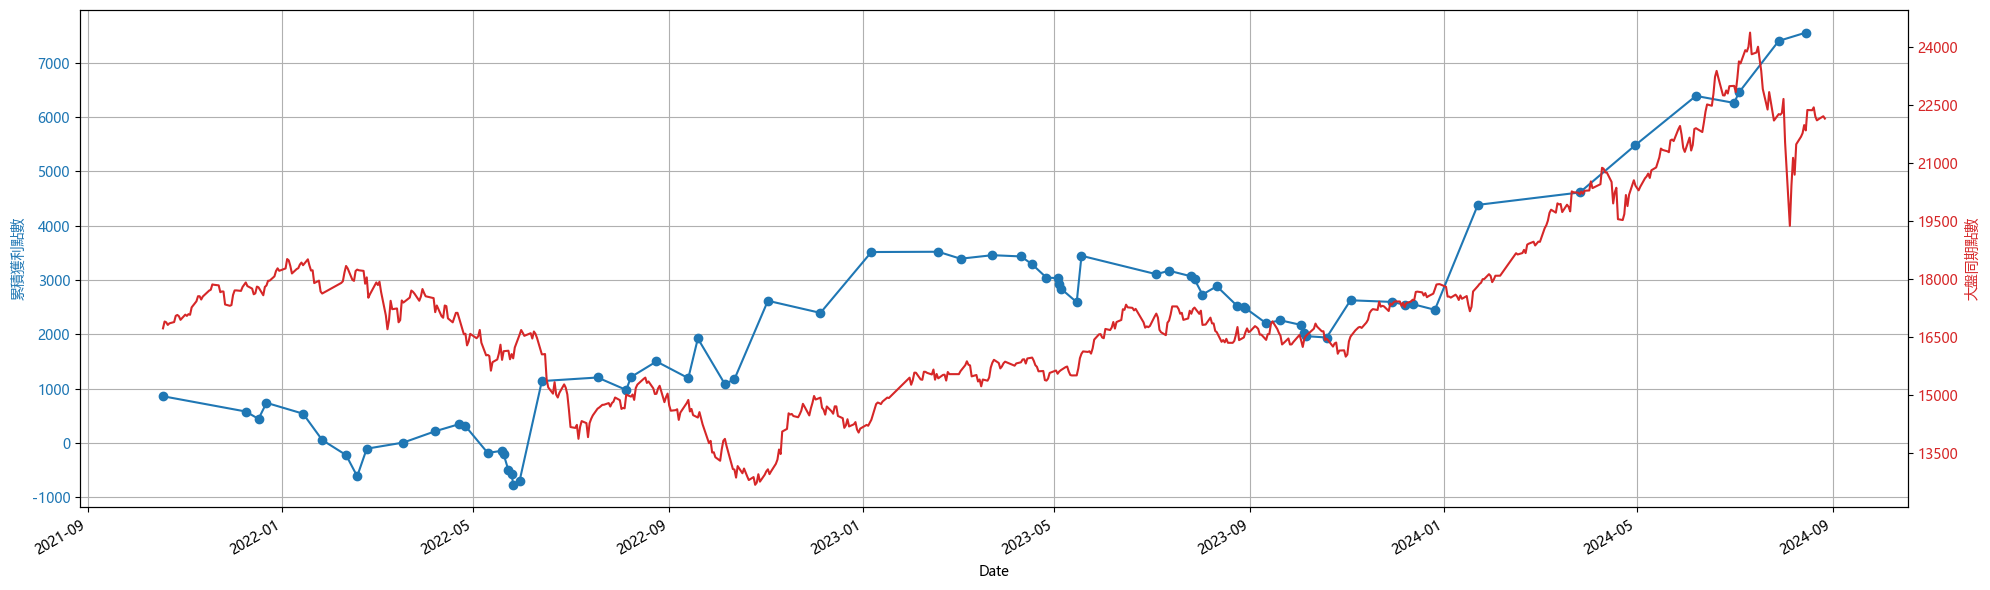

In [86]:
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore', category=FutureWarning)
from matplotlib.ticker import MaxNLocator

print_data = earm_data2_bs2

# 同期大盤資料 
tx_df = merged_df[( merged_df['Date'] >=  print_data['buy_date'].iloc[0]) & (merged_df['Date'] <= print_data['sell_date'].iloc[-1])]

print('===大盤累積====')
print(tx_df['最後成交價'].iloc[-1] - tx_df['最後成交價'].iloc[0])

print('===外資小兒法累積====')
print(print_data['earn'].cumsum().iloc[-1])

print('===進出次數====')
print(len(print_data))

print('===第一次買進===')
print(print_data['buy_date'].iloc[0])

print('===最後一次賣出===')
print(print_data['sell_date'].iloc[-1])

# 設置中文字體
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 使用微軟正黑體 (可根據系統字體選擇)
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題


# 假設 'Date' 已經是日期格式
fig, ax1 = plt.subplots(figsize=(20, 6))

# 第一條線 - 最後成交價
ax1.set_xlabel('Date')
ax1.set_ylabel('累積獲利點數', color='tab:blue')
ax1.plot(print_data['buy_date'], print_data['earn'].cumsum(), color='tab:blue', marker='o')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# 開啟網格
ax1.grid(True)
# 調整 Y 軸間距 (設定更多標籤)
ax1.yaxis.set_major_locator(MaxNLocator(prune=None, nbins=10))  # 增加 Y 軸標籤數量

# 建立第二個Y軸
ax2 = ax1.twinx()  
ax2.set_ylabel('大盤同期點數', color='tab:red')  # 可以根據需要調整標籤
ax2.plot(tx_df['Date'], tx_df['最後成交價'], color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# 調整第二個 Y 軸間距 (同樣設定更多標籤)
ax2.yaxis.set_major_locator(MaxNLocator(prune=None, nbins=10))  # 增加 Y 軸標籤數量

# 旋轉日期標籤
fig.autofmt_xdate()

# 顯示圖表
fig.tight_layout()
plt.show()


In [204]:
earm_data2['cumsum'] = earm_data2['earn'].cumsum()
earm_data2

,today_str,buy_date,sell_date,buy_open,sell_open,earn,cumsum
0,2021-10-15,2021-10-18,2021-11-23,16800.0,17659.0,859.0,859.0
1,2021-12-08,2021-12-09,2021-12-14,17886.0,17605.0,-281.0,578.0
2,2021-12-16,2021-12-17,2021-12-20,17716.0,17580.0,-136.0,442.0
3,2021-12-21,2021-12-22,2022-01-07,17847.0,18143.0,296.0,738.0
4,2022-01-13,2022-01-14,2022-01-18,18549.0,18349.0,-200.0,538.0
5,2022-02-09,2022-02-10,2022-02-15,18230.0,17953.0,-277.0,261.0
6,2022-02-16,2022-02-17,2022-02-22,18269.0,17878.0,-391.0,-130.0
7,2022-03-17,2022-03-18,2022-04-01,17441.0,17554.0,113.0,-17.0
8,2022-04-21,2022-04-22,2022-04-22,16862.0,16992.0,130.0,113.0
9,2022-05-18,2022-05-19,2022-05-19,15871.0,15911.0,40.0,153.0


In [87]:

# test = merged_df[merged_df['Date'].isin(earm_data1['buy_date'])][['Date', '開盤價' ,'最後成交價' ,'10MA','20MA']]

# test['開10'] = test['開盤價'] - test['10MA']
# test['收10'] = test['最後成交價'] - test['10MA']
# test


In [205]:
import numpy as np
import warnings
# 計算訊號出來 外資小兒翻多單
# 出場訊號出來後 隔天開盤直接賣
# 忽略 FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

MA = '10MA'

tx_df_raw = tx_df_raw[tx_df_raw[MA] != 0]
# tx_df_raw[tx_df_raw['最後成交價'] >= tx_df_raw['10MA']]

# tif_investors_df_raw['小外資變化'] = tif_investors_df_raw['小外資'].diff(1)

tif_investors_df_raw.dropna()

# 使用 'Date' 欄位進行內部連接
merged_df = pd.merge(tif_investors_df_raw, tx_df_raw, on='Date', how='inner')

merged_df['hold'] = np.nan

# 改成小外資多單的話進場
condition_buy = ((merged_df['最後成交價'] >=  merged_df[MA]) & (merged_df['小外資'] > 0))

condition_sell = (merged_df['最後成交價'] <  merged_df[MA])

merged_df.loc[condition_buy, 'hold'] = 1
merged_df.loc[condition_sell, 'hold'] = 0

merged_df['hold'].ffill(inplace=True)
merged_df['hold'] = merged_df['hold'].fillna(0)

# 計算進出

day_list = merged_df['Date'].unique().tolist()
earm_data3 = pd.DataFrame(columns=['buy_date','sell_date','buy_open','sell_open','earn'])

sell_date = pd.to_datetime("1911-01-01")  # Example Timestamp

for day in day_list:
        today_str = day.strftime('%Y-%m-%d')
        stock_df_today = merged_df[merged_df['Date'] == today_str].copy() 

        if((stock_df_today['hold'].iloc[0] == 1) & ( pd.to_datetime(today_str) > sell_date)): # 符合條件第一天
                #隔天開盤價買進
                buy_open = merged_df[merged_df['Date'] > today_str]['開盤價'].iloc[0] 
                buy_date = merged_df[merged_df['Date'] > today_str]['Date'].iloc[0] 


                #跌破ma當天
                sell_open = merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > today_str)]['最後成交價'].iloc[0] 
                sell_date = merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > today_str)]['Date'].iloc[0] 
                sell_date = pd.to_datetime(sell_date)

                earn = sell_open - buy_open

                result_df = pd.DataFrame({
                        'buy_date': [buy_date],
                        'sell_date': [sell_date],
                        'buy_open': [buy_open],
                        'sell_open': [sell_open],
                        'earn': [earn]
                        })

                # 删除全为NA的列，避免可能出现的警告
                result_df.dropna(axis=1, how='all', inplace=True)

                if not result_df.empty:
                        earm_data3 = pd.concat([earm_data3, result_df], ignore_index=True)

        


In [208]:
earm_data3['earncumsum'] = earm_data3['earn'].cumsum()
earm_data3



,buy_date,sell_date,buy_open,sell_open,earn,earncumsum
0,2022-07-14,2022-08-02,14237.0,14643.0,406.0,406.0
1,2022-08-08,2022-08-22,14937.0,15175.0,238.0,644.0
2,2022-09-13,2022-09-14,14884.0,14577.0,-307.0,337.0
3,2022-09-16,2022-09-16,14500.0,14483.0,-17.0,320.0
4,2022-10-06,2022-10-11,13932.0,13091.0,-841.0,-521.0
5,2022-10-28,2022-10-28,12855.0,12764.0,-91.0,-612.0
6,2022-11-01,2022-11-28,12960.0,14475.0,1515.0,903.0
7,2022-11-30,2022-12-06,14640.0,14675.0,35.0,938.0
8,2022-12-16,2022-12-16,14440.0,14461.0,21.0,959.0
9,2023-01-06,2023-02-15,14278.0,15398.0,1120.0,2079.0


===大盤累積====
7757.0
===外資小兒法累積====
6370.0
===進出次數====
32
===第一次買進===
2022-07-14 00:00:00
===最後一次賣出===
2024-08-27 00:00:00


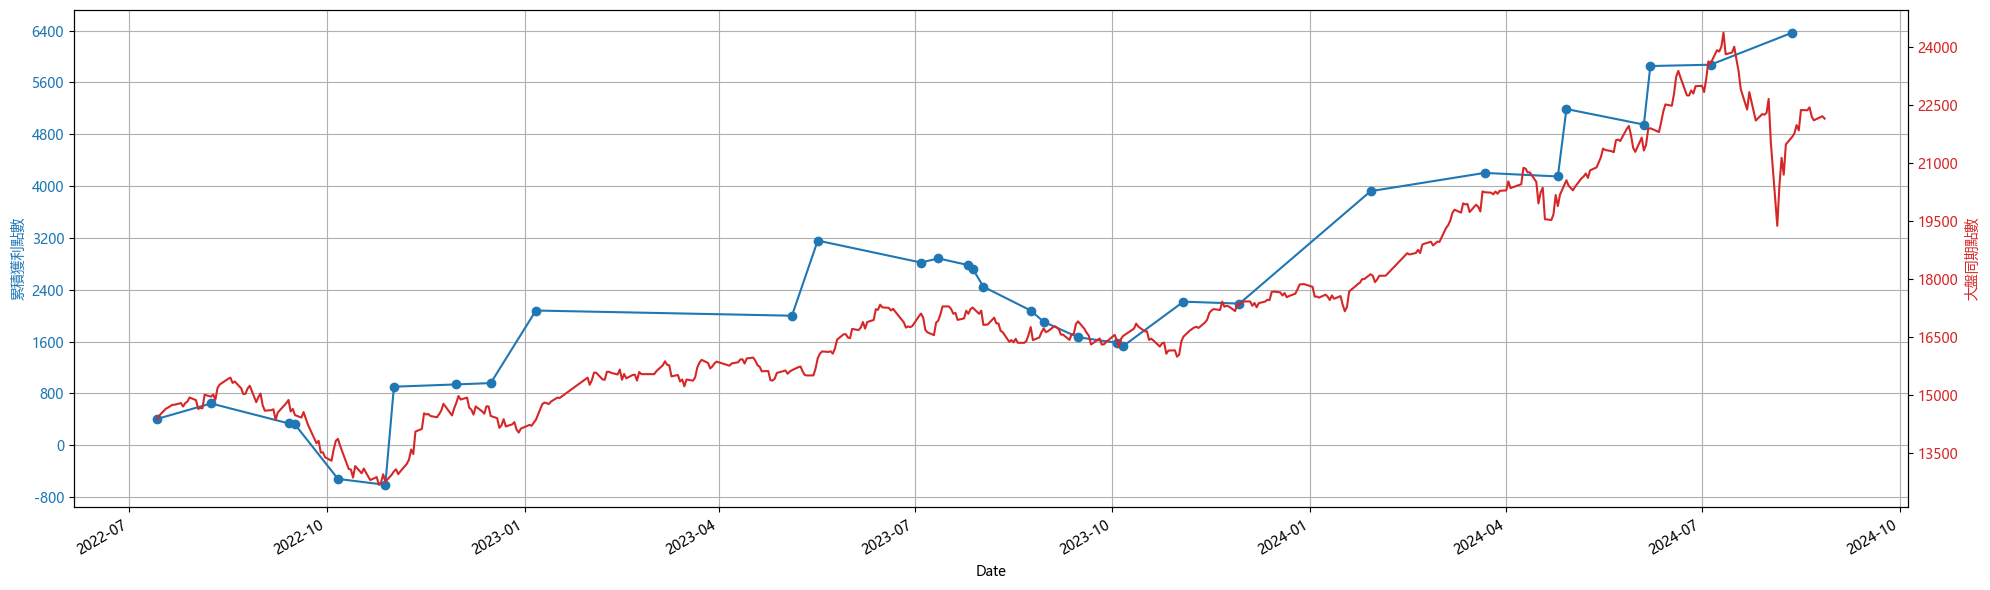

In [207]:
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore', category=FutureWarning)
from matplotlib.ticker import MaxNLocator

# 同期大盤資料 
tx_df = merged_df[( merged_df['Date'] >=  earm_data3['buy_date'].iloc[0]) & (merged_df['Date'] <= earm_data3['sell_date'].iloc[-1])]

print('===大盤累積====')
print(tx_df['最後成交價'].iloc[-1] - tx_df['最後成交價'].iloc[0])

print('===外資小兒法累積====')
print(earm_data3['earn'].cumsum().iloc[-1])

print('===進出次數====')
print(len(earm_data3))

print('===第一次買進===')
print(earm_data3['buy_date'].iloc[0])

print('===最後一次賣出===')
print(earm_data3['sell_date'].iloc[-1])

# 設置中文字體
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 使用微軟正黑體 (可根據系統字體選擇)
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題


# 假設 'Date' 已經是日期格式
fig, ax1 = plt.subplots(figsize=(20, 6))

# 第一條線 - 最後成交價
ax1.set_xlabel('Date')
ax1.set_ylabel('累積獲利點數', color='tab:blue')
ax1.plot(earm_data3['buy_date'], earm_data3['earn'].cumsum(), color='tab:blue', marker='o')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# 開啟網格
ax1.grid(True)
# 調整 Y 軸間距 (設定更多標籤)
ax1.yaxis.set_major_locator(MaxNLocator(prune=None, nbins=10))  # 增加 Y 軸標籤數量

# 建立第二個Y軸
ax2 = ax1.twinx()  
ax2.set_ylabel('大盤同期點數', color='tab:red')  # 可以根據需要調整標籤
ax2.plot(tx_df['Date'], tx_df['最後成交價'], color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# 調整第二個 Y 軸間距 (同樣設定更多標籤)
ax2.yaxis.set_major_locator(MaxNLocator(prune=None, nbins=10))  # 增加 Y 軸標籤數量

# 旋轉日期標籤
fig.autofmt_xdate()

# 顯示圖表
fig.tight_layout()
plt.show()


In [2]:
today = datetime.now()
today_str = datetime.now().strftime('%Y-%m-%d')
# 茶歷史資料 要再多查幾天
start_date_his = today - timedelta(days=40+10)
start_date = today - timedelta(days=40)

start_date_his = start_date_his.strftime('%Y%m%d')
start_date = start_date.strftime('%Y-%m-%d')

stock_date_list = stock_df_raw[(stock_df_raw['證券代號'] == '2330') & (stock_df_raw['Date']>= start_date ) & (stock_df_raw['Date'] < today_str )]['Date']


In [ ]:
stock_df_raw[(stock_df_raw['Date'] == '2024-10-09') & (stock_df_raw['證券代號'] == '8249')]

,Date,證券代號,證券名稱,成交股數,成交筆數,成交金額,開盤價,最高價,最低價,收盤價,...,60MA,60RS,20RS_sd,20RS_rank,60RS_sd,60RS_rank,240MA,240RS,240RS_sd,240RS_rank
1630960,2024-10-08,8249,菱光,14139111,9331,704870086,48.05,52.0,46.9,48.95,...,36.9958,132.3122,0.917663,6.337272,1.299653,97.905478,31.3156,156.3117,1.38112,96.401719


In [17]:
stock_date_list = stock_df_raw[(stock_df_raw['證券代號'] == '2330') & (stock_df_raw['Date']>= start_date ) & (stock_df_raw['Date'] < today_str )]['Date']

for day in stock_date_list:

    stock_df_today = stock_df_raw[(stock_df_raw['Date'] == stock_date_list.iloc[0]) &  
                                    (stock_df_raw['20RS_rank'] > 52) & 
                                    (stock_df_raw['60RS_rank'] > 90) & 
                                    (stock_df_raw['240RS_rank'] > 90) & 
                                    (stock_df_raw['收盤價'] > stock_df_raw['10MA'] )].copy() 
    stock_id_list = stock_df_today['證券代號'].tolist()
    for stock_id in stock_id_list:

            # 有day 跟 stock_id
            stock_his = stock_df_raw[(stock_df_raw['Date'] < day) & (stock_df_raw['證券代號'] == '5348' )]
            # 過去
            print('========')
            print(day)
            print(stock_id)
            print('========')
            rs20_rank_his = stock_his['20RS_rank'].iloc[-1]
            stock_today = stock_df_raw[(stock_df_raw['Date'] == day) & (stock_df_raw['證券代號'] == stock_id )].iloc[0]

2024-09-30 00:00:00
0061
2024-09-30 00:00:00
1235
2024-09-30 00:00:00
1569
2024-09-30 00:00:00
1721
2024-09-30 00:00:00
1727
2024-09-30 00:00:00
1736
2024-09-30 00:00:00
2033
2024-09-30 00:00:00
2062
2024-09-30 00:00:00
2243
2024-09-30 00:00:00
2360
2024-09-30 00:00:00
2497
2024-09-30 00:00:00
2543
2024-09-30 00:00:00
2615
2024-09-30 00:00:00
2923
2024-09-30 00:00:00
3013
2024-09-30 00:00:00
3040
2024-09-30 00:00:00
3081
2024-09-30 00:00:00
3085
2024-09-30 00:00:00
3149
2024-09-30 00:00:00
3167
2024-09-30 00:00:00
3227
2024-09-30 00:00:00
3230
2024-09-30 00:00:00
3354
2024-09-30 00:00:00
3430
2024-09-30 00:00:00
3450
2024-09-30 00:00:00
3665
2024-09-30 00:00:00
4527
2024-09-30 00:00:00
4530
2024-09-30 00:00:00
4549
2024-09-30 00:00:00
4563
2024-09-30 00:00:00
4571
2024-09-30 00:00:00
4716
2024-09-30 00:00:00
4729
2024-09-30 00:00:00
4760
2024-09-30 00:00:00
4903
2024-09-30 00:00:00
4909
2024-09-30 00:00:00
5234
2024-09-30 00:00:00
5348
2024-09-30 00:00:00
5438
2024-09-30 00:00:00
5481


IndexError: single positional indexer is out-of-bounds